# Introducción

En este documento se presenta el desarrollo completo del proceso de entrenamiento y validación de un modelo diseñado para clasificar e asignar puntuaciones a imágenes en función de su calidad. Se explorarán diversas estrategias de entrenamiento utilizando conjuntos de datos modificados con técnicas de normalización y transformaciones de reflexión y rotación, con el objetivo de seleccionar la configuración óptima. Se realizará la validación del modelo seleccionado y se calcularán diversas métricas para su evaluación comparativa. Además, se almacenarán los pesos del modelo para su uso futuro.

In [2]:

import os
import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
import time
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
from sklearn.metrics import confusion_matrix
from torch.utils.data import RandomSampler
import pandas as pd
from PIL import ImageFile



# Listar Imagenes 

# Imagenes entreno

In [3]:
Buena_calidad=os.listdir('..\Imagenes\Entreno\Buena calidad/')
Buena_calidad = list(filter(lambda x: x != 'Imagen', Buena_calidad))
Buena_calidad= list(map(lambda  p: f"..\Imagenes\Entreno\Buena calidad/{p}",Buena_calidad))
ImageFile.LOAD_TRUNCATED_IMAGES = True

Mala_calidad=os.listdir('..\Imagenes\Entreno\Mala Calidad/')
Mala_calidad = list(filter(lambda x: x != 'Imagen', Mala_calidad))
Mala_calidad= list(map(lambda  p: f"..\Imagenes\Entreno\Mala Calidad/{p}",Mala_calidad))

print("Total de imagenes de Buena calidad en el dataset de entreno", len(Buena_calidad))
print("Total de imagenes de Mala calidad en el dataset de entreno", len(Mala_calidad))

Total de imagenes de Buena calidad en el dataset de entreno 601
Total de imagenes de Mala calidad en el dataset de entreno 801


In [4]:
img_files = Buena_calidad + Mala_calidad

print("Imagenes totales", len(img_files))
random.shuffle(img_files) #Se randomizan

Imagenes totales 1402


In [5]:
index=round(len(img_files)*0.80, 0) 
index=int(index)

Se divide en entreno y test

In [6]:
ttrain = img_files[:index]
ttest = img_files[index:len(img_files)]

In [7]:
print("Tamaño de entreno:", len(ttrain))
print("Tamaño de test:", len(ttest))

Tamaño de entreno: 1122
Tamaño de test: 280


# Imagenes validacion

In [8]:
ValBuena_calidad=os.listdir('..\Imagenes\Validacion\Buena calidad/')
ValBuena_calidad = list(filter(lambda x: x != 'Imagen', ValBuena_calidad))
ValBuena_calidad= list(map(lambda  p: f"..\Imagenes\Validacion\Buena calidad/{p}",ValBuena_calidad))

ValMala_calidad=os.listdir('..\Imagenes\Validacion\Mala Calidad/')
ValMala_calidad = list(filter(lambda x: x != 'Imagen', ValMala_calidad))
ValMala_calidad= list(map(lambda  p: f"..\Imagenes\Validacion\Mala Calidad/{p}",ValMala_calidad))

print("Total de imagenes de Buena calidad en el dataset de validacion", len(ValBuena_calidad))
print("Total de imagenes de Mala calidad en el dataset de validacion", len(ValMala_calidad))

Total de imagenes de Buena calidad en el dataset de validacion 39
Total de imagenes de Mala calidad en el dataset de validacion 59


In [9]:
Val_Imagenes=ValMala_calidad+ValBuena_calidad
print("Imagenes de validacion totales", len(Val_Imagenes))
random.shuffle(Val_Imagenes)

Imagenes de validacion totales 98


# Generar dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((299,299)),#Las transforma a imagenes de 299x299
    transforms.ToTensor() #Transforma las imagenes a tensor
])

transform1 = transforms.Compose([ 
    transforms.RandomRotation(degrees=(60, 140)),#Realiza una rotacion entre 60/140 grados a todas las imagenes
    transforms.Resize((299,299)),   
    transforms.CenterCrop(180), #Se centra para eliminar las esquinas negras que aparecen
    transforms.Resize((299,299)), #Se vuelve al tamaño 299x299
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomRotation(degrees=(200, 340)), #Realiza una rotacion entre 200/340 grados a todas las imagenes
    transforms.CenterCrop(180),
    transforms.Resize((299,299)),
    transforms.ToTensor()
])


transform3 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(p=1), #Realiza un flip horizontal a todas las imagenes
    transforms.ToTensor()
])

transform4 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomVerticalFlip(p=1), #Realiza un flip vertical a todas las imagenes
    transforms.ToTensor()
])



# Constructor del dataset.
class goodBadDataset(Dataset):
    def __init__(self, image_paths, transform):
      super().__init__()
      self.paths = image_paths
      self.len = len(self.paths)
      self.transform = transform

    def __len__(self):
      return self.len

    def __getitem__(self, index):
      path = self.paths[index]
      image = Image.open(path)
      image = self.transform(image)
      label = 0 if 'Buena calidad' in path else 1 #Si en el path se encuentra el texto buena calidad se le coloca la etiqueta 0 si no un 1.
      return (image,label,path) #Devuelve la imagen, su etiqueta y su path

## Dataset de entreno sin transformar y con transformaciones 

In [18]:

train_ds2= goodBadDataset(ttrain,transform) #Se genera un dataset de entreno con solo las imagenes pasadas a tensor y con tamaño 299x299

train_dsx=goodBadDataset(ttrain,transform1)#+goodBadDataset(ttrain,transform1)+goodBadDataset(ttrain,transform2)+goodBadDataset(ttrain,transform3)+goodBadDataset(ttrain,transform4) # #Se genera un dataset de entreno con todas las transformaciones expuestas anteriormente a las imagenesy se pasan a tensor.


#Randomizar las imagenes del dataset de entreno con las imagenes transformadas
random_train_idx = np.random.choice(np.array(range(len(train_dsx))),replace=False, size=train_dsx.__len__())
train_subset = Subset(train_dsx, random_train_idx)
train_dlx=DataLoader(train_subset,batch_size=100,shuffle=True)

#Se carga el dataset de entreno y se divide en batches de 100 imagenes
train_dl2=DataLoader(train_ds2,batch_size=100,shuffle=True)
print("Longitud del dataset de entreno sin transformaciones: ",len(train_ds2))
print("Longitud del dataset de entreno con transformaciones: ",len(train_dsx))
print("Cantidad de batches de 100 del dataloader de entreno sin transformaciones: ",len(train_dl2))
print("Cantidad de batches de 100 del dataloader de entreno con transformaciones: ",len(train_dlx))

test_ds2 = goodBadDataset(ttest, transform) #Se carga el dataset de test con solo imagenes pasadas a tensor y de tamaño 299x299
test_dl2 = DataLoader(test_ds2, batch_size=50) #Se carga el dataloader de test y se divide en batches de 50 imagenes

print("Longitud del dataset de test sin transformaciones: ",len(test_ds2))
print("Cantidad de batches de 100 del dataloader de test sin transformaciones: ",len(test_dl2))

Longitud del dataset de entreno sin transformaciones:  1122
Longitud del dataset de entreno con transformaciones:  1122
Cantidad de batches de 100 del dataloader de entreno sin transformaciones:  12
Cantidad de batches de 100 del dataloader de entreno con transformaciones:  12
Longitud del dataset de test sin transformaciones:  280
Cantidad de batches de 100 del dataloader de test sin transformaciones:  6


## Dataset de validacion sin normalizar 

In [7]:
val_ds2 = goodBadDataset(Val_Imagenes, transform) #Se carga el dataset de validacion con solo imagenes pasadas a tensor y de tamaño 299x299
val_dl2 = DataLoader(val_ds2, batch_size=4) #Se carga el dataloader de validacion.

print("Longitud del dataset de validacion sin normalizar: ",len(val_ds2))
print("Cantidad de batches de 100 del dataloader de validacion sin normalizar: ",len(val_dl2))

Longitud del dataset de validacion sin normalizar:  98
Cantidad de batches de 100 del dataloader de validacion sin normalizar:  25


# Normalizar Imagenes

In [13]:
#Se calcula el mean y std  de todas las imagenes originales del dataset sin transformaciones para poder normalizar las imagenes
def mean_std_for_loader1(loader: DataLoader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X,_,_ in loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    #Se divide el mean y el std acumulado de todas las imagenes entre la longitud del dataloader.
    mean.div_(len(loader)) 
    std.div_(len(loader))
    return list(mean.numpy()), list(std.numpy())

means, stds = mean_std_for_loader1(train_dl2)
print(means)
print(stds)

[0.32598773, 0.3410391, 0.33474925]
[0.20066549, 0.18762441, 0.22126186]


In [14]:
normalize = transforms.Normalize(means, stds)

In [15]:
transformN = transforms.Compose([#Se genera la transformacion con la normalizacion generada anteriormente
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    normalize
])


In [16]:
train_ds= goodBadDataset(ttrain,transformN)#Se genera un dataset de entreno con las imagenes normalizadas y de tamaño 299x299

train_dl=DataLoader(train_ds,batch_size=100,shuffle=True)
print("Longitud del dataset de entreno sin transformaciones:",len(train_ds))
print("Cantidad de batches de 100 del dataloader de entreno sin transformaciones:",len(train_dl))

test_ds = goodBadDataset(ttest, transformN)
test_dl = DataLoader(test_ds, batch_size=50)
print("Longitud del dataset de test sin transformaciones: ",len(test_ds))
print("Cantidad de batches de 100 del dataloader de test sin transformaciones: ",len(test_dl))

Longitud del dataset de entreno sin transformaciones: 1122
Cantidad de batches de 100 del dataloader de entreno sin transformaciones: 12
Longitud del dataset de test sin transformaciones:  280
Cantidad de batches de 100 del dataloader de test sin transformaciones:  6


## Dataset de validacion normalizado 

In [49]:
val_ds = goodBadDataset(Val_Imagenes, transformN)
val_dl = DataLoader(val_ds, batch_size=4)
print("Longitud del dataset de validacion normalizado: ",len(val_ds))
print("Cantidad de batches de 100 del dataloader de validacion normalizado: ",len(val_dl))

Longitud del dataset de validacion normalizado:  98
Cantidad de batches de 100 del dataloader de validacion normalizado:  25


# Visualizar imagenes

Label:  0
path:  ..\Imagenes\Entreno\Buena calidad/Imagen84_5050.png


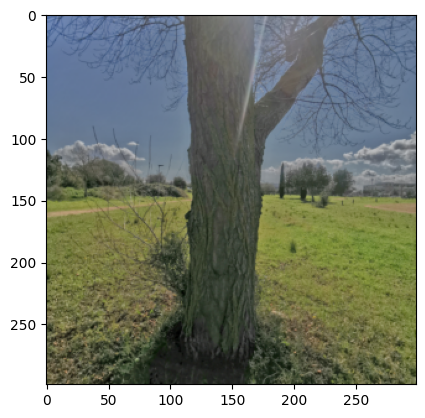

In [20]:
#Se coge una imagen del dataloader de entreno sin normalizar y sin transformar y se muestra para ver que se han guardado correctamente
x=5
img = np.array(train_dl2.dataset[x][0])


img = np.moveaxis(img, 0, -1) #Se mueve los canales para que el de color este el ultimo

print("Label: " ,train_dl2.dataset[x][1]) #Se imprime su etiqueta
print("path: " ,train_dl2.dataset[x][2])
plt.imshow(img )
plt.show()

Label:  1
path:  ..\Imagenes\Entreno\Mala Calidad/Imagen403_8025.png


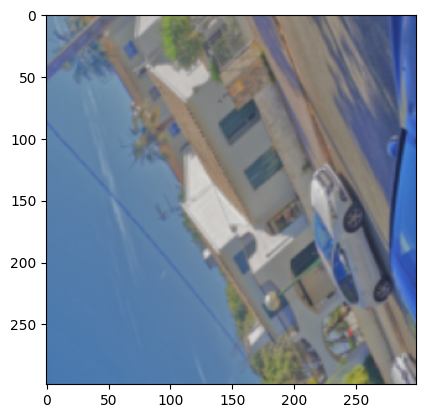

In [34]:
#Se coge una imagen del dataloader de entreno normalizado y sin transformar y se muestra para ver que se han guardado correctamente

x=100

img = np.array(train_dlx.dataset[x][0])


img = np.moveaxis(img, 0, -1)

print("Label: " ,train_dlx.dataset[x][1])
print("path: " ,train_dlx.dataset[x][2])
plt.imshow(img )
plt.show()

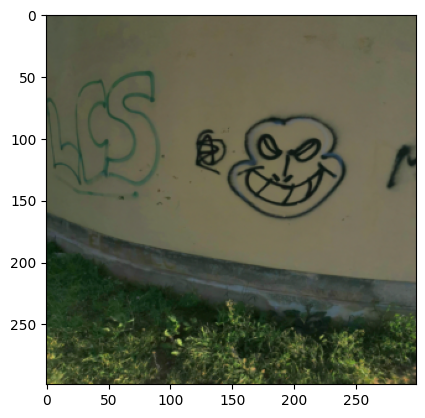

Label:  0


In [52]:
#Se coge una imagen del dataloader de validacion no normalizado y se muestra para ver que se han guardado correctamente

x=0

img = np.array(val_dl2.dataset[x][0])


img = np.moveaxis(img, 0, -1)
plt.imshow(img)
plt.show()
print("Label: " ,val_dl2.dataset[x][1])

# Distribucion de imagenes buenas y malas en el test

In [53]:
count_Good=0
count_Bad=0

for i in range(test_ds2. __len__()): #Se suma el numero de imagenes con etiqueta en 0 o en 1.
    if test_ds2.__getitem__(i)[1]==0:
        count_Good=count_Good+1
    else:
        count_Bad=count_Bad+1
        

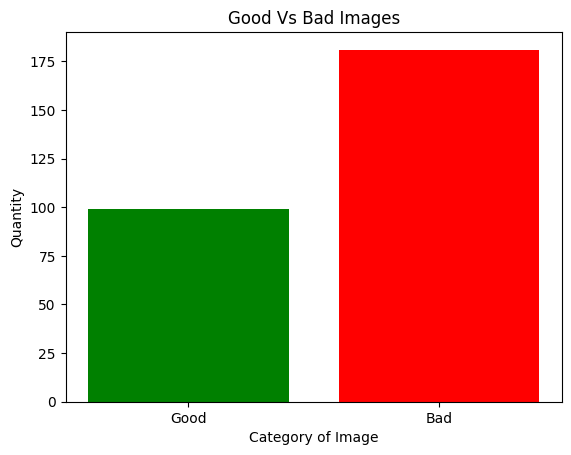

In [54]:

xcoordinates=[1, 2] #Solo hay dos grupos.
  

height = [count_Good, count_Bad] #Se indica la altura de cada uno
  

tick_label = ['Good', 'Bad'] #Etiquetas de los grupos
  

plt.bar(xcoordinates, height, tick_label = tick_label,
        width = 0.8, color = ['green', 'red']) #Se muestra un grafico de barras con la barra de buenas a color ver y de mala a rojo
  

plt.xlabel('Category of Image') #Nombrar las coodenadas x

plt.ylabel('Quantity') #Nombrar las coodenadas y

plt.title('Good Vs Bad Images') #Nombrar el titulo del grafico
  

plt.show() #Se muestra el grafico

A causa de la diferencia que hay entre imagenes buenas y malas, en el test se encuentran mas imagenes malas que buenas.

# Algoritmo de entreno

In [55]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10, verbose=True):
    
    model.train() #Se pone en estado de entreno

    loss_v = 0

    correct=0
    
    for batch_idx, (data, target,_) in enumerate(train_loader): #Por cada batch en el dataset
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
        loss.backward()
        optimizer.step()
        if verbose:
            if len(data)==100:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
            else:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                    epoch,len(train_loader.dataset)-len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item() #Si se ha predecido bien se suma.
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    accuracy=correct / len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss_v, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    
 
    
    return loss_v,accuracy # Se devuelve la perdida y la precision conseguida


def test(model, device, test_loader):
    model.eval() #Se pone en estado de evaluacion
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target,_ in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item() #Se suma si se ha predecido de forma correcta la etiqueta
 
  
    test_loss /= len(test_loader.dataset) #Se calcula la media de la perdida

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    
    accuracy=correct / len(test_loader.dataset)
    return test_loss,accuracy # Se devuelve la perdida y la precision conseguida

# Definicion del modelo

In [56]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [66]:

    
def initialize_model2(num_classes):
    #Los pesos si se entrenan
    model_ft = models.inception_v3(weights=False) #Se carga el modelo inception_v3 sin sus pesos preentrenados.
    # False en las redes convencionales, se entrenaran
    set_parameter_requires_grad(model_ft, False)
    # Se modifica la red auxiliar
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

    # Se modifica la red principal para que sea de dos clases con una salida softmax y coger la con mas probabilidad.
    model_ft.dropout= nn.Dropout(0.5)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Dropout(0.3),
        nn.Softmax(dim=1)
    )


    input_size=299 #Tamaño que usa la red
    return model_ft,input_size

model_ftNor,_=initialize_model2(2) #Se inicializa el modelo que se usara para los datos normalizados
model_ftNN,_= initialize_model2(2) #Se inicializa el modelo que se usara para los datos no normalizados
device = torch.device("cpu") #Se indica el device, por terminos de hardware la opcion de gpu no es viable en el ordenador de entreno

print("Estructura del modelo inceptionV3 modificado para que clasifique dos clases:",model_ftNN)

Estructura del modelo inceptionV3 modificado para que clasifique dos clases: Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv

# Experimentos

Hipotesis principal: El entreno del clasificador funcionara de forma mas eficiente si se utilizan imagenes no normalizadas y sin transformar el conjunto de imagenes con rotaciones. Esta creencia surge de que la el objetivo es que sea capaz de distinguir las diferentes caracteristicas del color de una imagen, es decir, si esta saturada o es oscura para indicar que es de mala calidad o comprobar si su brillo es correcto y no tiene ningun artefacto a simple vista y colocarlo en buena calidad.


A continuacion se exponen los distintos entrenos realizados con un rango de epocas, que permite visualizar esa decadencia en los modelos con los datos mencionados. Se mostraran entrenos empezando con 5 epocas y añadiendo mas epocas para poder ver su evolucion.

## Modelo con Datos Normalizados 

In [67]:
model_ftNor.aux_logits=False #Se indica que no se utilice la capa auxiliar.

modelNor=model_ftNor.to(device) #Se indica el device



params_to_updateNor = model_ftNor.parameters()
print("Params to learn:")
params_to_updateNor = []
#Se muestra el nombre de los parametros a entrenar
for name,param in model_ftNor.named_parameters():
    
    if (param.requires_grad == True) & (not ('AuxLogits' in name)):
        params_to_updateNor.append(param)
        print("\t",name)


parametrosNor=sum(p.numel() for p in params_to_updateNor) #Total de parametros a actualizar





Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [68]:

epochs=4 #Numero de epocas iniciales de entreno
lr=0.0001



print("Parameters ",parametrosNor) #Numero de parametros
optimizerNor = optim.Adam(params_to_updateNor, lr=lr) #Se usa el optimizador Adam.

#Se guarda el valor de la perdida media y de su precisión
train_l = np.zeros((12))
accuracy_train = np.zeros((12))
test_l = np.zeros((12))
accuracy_test = np.zeros((12))
print("Entranamiento de la red con datos normalizados")
# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch],accuracy_train[epoch] = train(modelNor, device, train_dl, optimizerNor, epoch)
    test_l[epoch],accuracy_test[epoch]  = test(modelNor, device, test_dl)

Parameters  21789666
Entranamiento de la red con datos normalizados
Train Epoch: 0 [0/1122 (0%)]	Loss: 71.799110, Average: 0.717991
Train Epoch: 0 [100/1122 (8%)]	Loss: 71.285156, Average: 0.712852
Train Epoch: 0 [200/1122 (17%)]	Loss: 68.744316, Average: 0.687443
Train Epoch: 0 [300/1122 (25%)]	Loss: 69.799446, Average: 0.697994
Train Epoch: 0 [400/1122 (33%)]	Loss: 67.824142, Average: 0.678241
Train Epoch: 0 [500/1122 (42%)]	Loss: 68.682663, Average: 0.686827
Train Epoch: 0 [600/1122 (50%)]	Loss: 67.021126, Average: 0.670211
Train Epoch: 0 [700/1122 (58%)]	Loss: 65.826561, Average: 0.658266
Train Epoch: 0 [800/1122 (67%)]	Loss: 60.126282, Average: 0.601263
Train Epoch: 0 [900/1122 (75%)]	Loss: 64.252678, Average: 0.642527
Train Epoch: 0 [1000/1122 (83%)]	Loss: 61.589169, Average: 0.615892
Train Epoch: 0 [1100/1122 (92%)]	Loss: 13.372444, Average: 0.607838

Train set: Average loss: 0.6687, Accuracy: 660/1122 (59%)


Test set: Average loss: 0.7878, Accuracy: 147/280 (52%)

Train Epoch:

A continuacion hay entrenos auxiliares para demostrar como la hipotesis de que el entreno del clasificador con imagenes normalizadas decrece su precision en la validacion que se podra ver mas adelante. Esto se debe a que el clasificador quiere clasificar como es el color de las imagenes , si oscuro, saturado o correcto, y por ello a bajarlo a una escala de 0/1 no consigue distinguir bien esos cambios.

In [86]:
train_l[0],accuracy_train[4] = train(model, device, train_dl, optimizer2, 0)#5
test_l[0],accuracy_test[4]  = test(model, device, test_dl)

Train Epoch: 0 [0/1122 (0%)]	Loss: 44.300961, Average: 0.443010
Train Epoch: 0 [100/1122 (8%)]	Loss: 45.199955, Average: 0.452000
Train Epoch: 0 [200/1122 (17%)]	Loss: 47.588795, Average: 0.475888
Train Epoch: 0 [300/1122 (25%)]	Loss: 46.097858, Average: 0.460979
Train Epoch: 0 [400/1122 (33%)]	Loss: 45.040234, Average: 0.450402
Train Epoch: 0 [500/1122 (42%)]	Loss: 40.887291, Average: 0.408873
Train Epoch: 0 [600/1122 (50%)]	Loss: 42.978642, Average: 0.429786
Train Epoch: 0 [700/1122 (58%)]	Loss: 39.310867, Average: 0.393109
Train Epoch: 0 [800/1122 (67%)]	Loss: 39.007698, Average: 0.390077
Train Epoch: 0 [900/1122 (75%)]	Loss: 42.123089, Average: 0.421231
Train Epoch: 0 [1000/1122 (83%)]	Loss: 41.907116, Average: 0.419071
Train Epoch: 0 [1100/1122 (92%)]	Loss: 9.140339, Average: 0.415470

Train set: Average loss: 0.4310, Accuracy: 994/1122 (89%)


Test set: Average loss: 0.4358, Accuracy: 244/280 (87%)



In [107]:

train_l[5],accuracy_train[5] = train(model, device, train_dl, optimizer2, 5)#6
test_l[5],accuracy_test[5]  = test(model, device, test_dl)

Train Epoch: 5 [0/1122 (0%)]	Loss: 44.913395, Average: 0.449134
Train Epoch: 5 [100/1122 (8%)]	Loss: 42.132908, Average: 0.421329
Train Epoch: 5 [200/1122 (17%)]	Loss: 43.175121, Average: 0.431751
Train Epoch: 5 [300/1122 (25%)]	Loss: 41.526623, Average: 0.415266
Train Epoch: 5 [400/1122 (33%)]	Loss: 39.988209, Average: 0.399882
Train Epoch: 5 [500/1122 (42%)]	Loss: 41.300728, Average: 0.413007
Train Epoch: 5 [600/1122 (50%)]	Loss: 39.578026, Average: 0.395780
Train Epoch: 5 [700/1122 (58%)]	Loss: 39.657864, Average: 0.396579
Train Epoch: 5 [800/1122 (67%)]	Loss: 43.872017, Average: 0.438720
Train Epoch: 5 [900/1122 (75%)]	Loss: 38.570030, Average: 0.385700
Train Epoch: 5 [1000/1122 (83%)]	Loss: 39.146111, Average: 0.391461
Train Epoch: 5 [1100/1122 (92%)]	Loss: 10.215929, Average: 0.464360

Train set: Average loss: 0.4136, Accuracy: 1003/1122 (89%)


Test set: Average loss: 0.4301, Accuracy: 248/280 (89%)



In [115]:

train_l[6],accuracy_train[6] = train(model, device, train_dl, optimizer2, 6)#7
test_l[6],accuracy_test[6]  = test(model, device, test_dl)

Train Epoch: 6 [0/1122 (0%)]	Loss: 45.365822, Average: 0.453658
Train Epoch: 6 [100/1122 (8%)]	Loss: 41.250031, Average: 0.412500
Train Epoch: 6 [200/1122 (17%)]	Loss: 38.392948, Average: 0.383929
Train Epoch: 6 [300/1122 (25%)]	Loss: 39.706207, Average: 0.397062
Train Epoch: 6 [400/1122 (33%)]	Loss: 40.698811, Average: 0.406988
Train Epoch: 6 [500/1122 (42%)]	Loss: 40.475204, Average: 0.404752
Train Epoch: 6 [600/1122 (50%)]	Loss: 40.200981, Average: 0.402010
Train Epoch: 6 [700/1122 (58%)]	Loss: 41.136497, Average: 0.411365
Train Epoch: 6 [800/1122 (67%)]	Loss: 41.274956, Average: 0.412750
Train Epoch: 6 [900/1122 (75%)]	Loss: 44.559540, Average: 0.445595
Train Epoch: 6 [1000/1122 (83%)]	Loss: 40.466072, Average: 0.404661
Train Epoch: 6 [1100/1122 (92%)]	Loss: 8.961942, Average: 0.407361

Train set: Average loss: 0.4122, Accuracy: 988/1122 (88%)


Test set: Average loss: 0.3748, Accuracy: 262/280 (94%)



In [123]:

train_l[7],accuracy_train[7] = train(model, device, train_dl, optimizer2, 7)#8
test_l[7],accuracy_test[7]  = test(model, device, test_dl)

Train Epoch: 7 [0/1122 (0%)]	Loss: 37.085503, Average: 0.370855
Train Epoch: 7 [100/1122 (8%)]	Loss: 39.652756, Average: 0.396528
Train Epoch: 7 [200/1122 (17%)]	Loss: 44.426235, Average: 0.444262
Train Epoch: 7 [300/1122 (25%)]	Loss: 39.046284, Average: 0.390463
Train Epoch: 7 [400/1122 (33%)]	Loss: 36.750862, Average: 0.367509
Train Epoch: 7 [500/1122 (42%)]	Loss: 38.564941, Average: 0.385649
Train Epoch: 7 [600/1122 (50%)]	Loss: 36.869785, Average: 0.368698
Train Epoch: 7 [700/1122 (58%)]	Loss: 39.713581, Average: 0.397136
Train Epoch: 7 [800/1122 (67%)]	Loss: 39.717514, Average: 0.397175
Train Epoch: 7 [900/1122 (75%)]	Loss: 40.556702, Average: 0.405567
Train Epoch: 7 [1000/1122 (83%)]	Loss: 38.251358, Average: 0.382514
Train Epoch: 7 [1100/1122 (92%)]	Loss: 8.982673, Average: 0.408303

Train set: Average loss: 0.3918, Accuracy: 1032/1122 (92%)


Test set: Average loss: 0.3974, Accuracy: 257/280 (92%)



In [130]:
train_l[8],accuracy_train[8] = train(model, device, train_dl, optimizer2, 8)#9
test_l[8],accuracy_test[8]  = test(model, device, test_dl)

Train Epoch: 8 [0/1122 (0%)]	Loss: 38.484978, Average: 0.384850
Train Epoch: 8 [100/1122 (8%)]	Loss: 37.937038, Average: 0.379370
Train Epoch: 8 [200/1122 (17%)]	Loss: 36.103897, Average: 0.361039
Train Epoch: 8 [300/1122 (25%)]	Loss: 39.215015, Average: 0.392150
Train Epoch: 8 [400/1122 (33%)]	Loss: 36.794659, Average: 0.367947
Train Epoch: 8 [500/1122 (42%)]	Loss: 34.533199, Average: 0.345332
Train Epoch: 8 [600/1122 (50%)]	Loss: 38.644371, Average: 0.386444
Train Epoch: 8 [700/1122 (58%)]	Loss: 36.706749, Average: 0.367067
Train Epoch: 8 [800/1122 (67%)]	Loss: 39.993988, Average: 0.399940
Train Epoch: 8 [900/1122 (75%)]	Loss: 38.235481, Average: 0.382355
Train Epoch: 8 [1000/1122 (83%)]	Loss: 35.987534, Average: 0.359875
Train Epoch: 8 [1100/1122 (92%)]	Loss: 8.394258, Average: 0.381557

Train set: Average loss: 0.3753, Accuracy: 1041/1122 (93%)


Test set: Average loss: 0.3816, Accuracy: 260/280 (93%)



In [135]:
train_l[9],accuracy_train[9] = train(model, device, train_dl, optimizer2, 9)#10
test_l[9],accuracy_test[9]  = test(model, device, test_dl)

Train Epoch: 9 [0/1122 (0%)]	Loss: 35.996075, Average: 0.359961
Train Epoch: 9 [100/1122 (8%)]	Loss: 37.245811, Average: 0.372458
Train Epoch: 9 [200/1122 (17%)]	Loss: 39.243862, Average: 0.392439
Train Epoch: 9 [300/1122 (25%)]	Loss: 38.120831, Average: 0.381208
Train Epoch: 9 [400/1122 (33%)]	Loss: 37.545128, Average: 0.375451
Train Epoch: 9 [500/1122 (42%)]	Loss: 37.978355, Average: 0.379784
Train Epoch: 9 [600/1122 (50%)]	Loss: 37.065701, Average: 0.370657
Train Epoch: 9 [700/1122 (58%)]	Loss: 40.205593, Average: 0.402056
Train Epoch: 9 [800/1122 (67%)]	Loss: 38.718380, Average: 0.387184
Train Epoch: 9 [900/1122 (75%)]	Loss: 37.831638, Average: 0.378316
Train Epoch: 9 [1000/1122 (83%)]	Loss: 36.584656, Average: 0.365847
Train Epoch: 9 [1100/1122 (92%)]	Loss: 9.506979, Average: 0.432135

Train set: Average loss: 0.3797, Accuracy: 1033/1122 (92%)


Test set: Average loss: 0.3667, Accuracy: 265/280 (95%)



In [142]:
train_l[10],accuracy_train[10] = train(model, device, train_dl, optimizer2, 10)#11
test_l[10],accuracy_test[10]  = test(model, device, test_dl)

Train Epoch: 10 [0/1122 (0%)]	Loss: 34.239700, Average: 0.342397
Train Epoch: 10 [100/1122 (8%)]	Loss: 36.643440, Average: 0.366434
Train Epoch: 10 [200/1122 (17%)]	Loss: 37.773331, Average: 0.377733
Train Epoch: 10 [300/1122 (25%)]	Loss: 34.663967, Average: 0.346640
Train Epoch: 10 [400/1122 (33%)]	Loss: 38.841770, Average: 0.388418
Train Epoch: 10 [500/1122 (42%)]	Loss: 36.418854, Average: 0.364189
Train Epoch: 10 [600/1122 (50%)]	Loss: 36.523460, Average: 0.365235
Train Epoch: 10 [700/1122 (58%)]	Loss: 36.582550, Average: 0.365826
Train Epoch: 10 [800/1122 (67%)]	Loss: 37.335312, Average: 0.373353
Train Epoch: 10 [900/1122 (75%)]	Loss: 39.254124, Average: 0.392541
Train Epoch: 10 [1000/1122 (83%)]	Loss: 38.683319, Average: 0.386833
Train Epoch: 10 [1100/1122 (92%)]	Loss: 8.159461, Average: 0.370885

Train set: Average loss: 0.3700, Accuracy: 1050/1122 (94%)


Test set: Average loss: 0.3749, Accuracy: 264/280 (94%)



#### Grafica de precisión

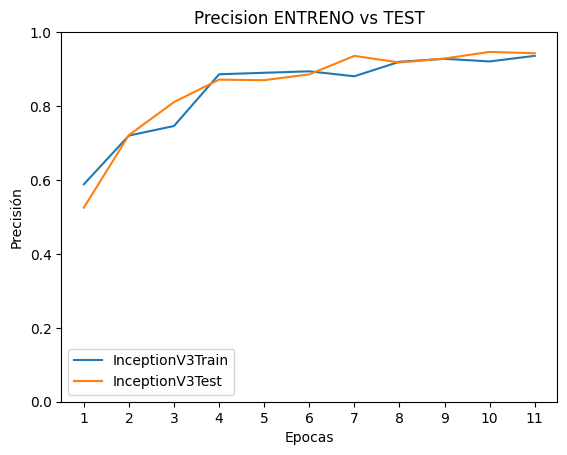

In [161]:
plt.title("Precision ENTRENO vs TEST")
plt.xlabel("Epocas")
plt.ylabel("Precisión")
plt.plot(range(1,epochs+1),accuracy_train[0:epochs],label="InceptionV3Train")
plt.plot(range(1,epochs+1),accuracy_test[0:epochs],label="InceptionV3Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.show()

# Sin Normalizar
 

In [69]:
model_ftNN.aux_logits=False
modelNN = model_ftNN.to(device)
params_to_updateNN = model_ftNN.parameters()
print("Params to learn:")
params_to_updateNN = []
for name,param in model_ftNN.named_parameters():
    
    if (param.requires_grad == True) & (not ('AuxLogits' in name)):
        params_to_updateNN.append(param)
        print("\t",name)


print(model_ftNN.fc)


parametrosNN=sum(p.numel() for p in params_to_updateNN)


Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [70]:
epochs=4
lr=0.0001



print("Parameters ",parametrosNN)
optimizerNN = optim.Adam(params_to_updateNN, lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_lNN = np.zeros((12))
accuracy_trainNN = np.zeros((12))
test_lNN = np.zeros((12))
accuracy_testNN = np.zeros((12))
print("Entranamiento de la red con datos no normalizados")
# Bucle d'entrenament
for epoch in range(0, epochs):
    train_lNN[epoch],accuracy_trainNN[epoch] = train(modelNN, device, train_dl2, optimizerNN, epoch)
    test_lNN[epoch],accuracy_testNN[epoch]  = test(modelNN, device, test_dl2)

Parameters  21789666
Entranamiento de la red con datos no normalizados
Train Epoch: 0 [0/1122 (0%)]	Loss: 69.304146, Average: 0.693041
Train Epoch: 0 [100/1122 (8%)]	Loss: 67.001160, Average: 0.670012
Train Epoch: 0 [200/1122 (17%)]	Loss: 67.575996, Average: 0.675760
Train Epoch: 0 [300/1122 (25%)]	Loss: 67.769585, Average: 0.677696
Train Epoch: 0 [400/1122 (33%)]	Loss: 68.268936, Average: 0.682689
Train Epoch: 0 [500/1122 (42%)]	Loss: 66.443916, Average: 0.664439
Train Epoch: 0 [600/1122 (50%)]	Loss: 64.985680, Average: 0.649857
Train Epoch: 0 [700/1122 (58%)]	Loss: 62.508446, Average: 0.625084
Train Epoch: 0 [800/1122 (67%)]	Loss: 61.400085, Average: 0.614001
Train Epoch: 0 [900/1122 (75%)]	Loss: 64.753494, Average: 0.647535
Train Epoch: 0 [1000/1122 (83%)]	Loss: 61.202393, Average: 0.612024
Train Epoch: 0 [1100/1122 (92%)]	Loss: 13.299751, Average: 0.604534

Train set: Average loss: 0.6546, Accuracy: 709/1122 (63%)


Test set: Average loss: 0.6668, Accuracy: 181/280 (65%)

Train Epo

A continuacion hay entrenos auxiliares para demostrar como la hipotesis de que el entreno del clasificador con imagenes no normalizadas aumenta su precision en la validacion con respecto a los otros modelos que se podra ver mas adelante.

In [90]:
train_lNN[4],accuracy_trainNN[4] = train(modelNN, device, train_dl2, optimizerNN, 4)#5
test_lNN[4],accuracy_testNN[4]  = test(modelNN, device, test_dl2)
epochs=epochs+1

Train Epoch: 4 [0/1122 (0%)]	Loss: 48.720665, Average: 0.487207
Train Epoch: 4 [100/1122 (8%)]	Loss: 46.957470, Average: 0.469575
Train Epoch: 4 [200/1122 (17%)]	Loss: 45.244396, Average: 0.452444
Train Epoch: 4 [300/1122 (25%)]	Loss: 45.178307, Average: 0.451783
Train Epoch: 4 [400/1122 (33%)]	Loss: 45.422169, Average: 0.454222
Train Epoch: 4 [500/1122 (42%)]	Loss: 48.241394, Average: 0.482414
Train Epoch: 4 [600/1122 (50%)]	Loss: 43.073982, Average: 0.430740
Train Epoch: 4 [700/1122 (58%)]	Loss: 44.198616, Average: 0.441986
Train Epoch: 4 [800/1122 (67%)]	Loss: 48.681858, Average: 0.486819
Train Epoch: 4 [900/1122 (75%)]	Loss: 42.955074, Average: 0.429551
Train Epoch: 4 [1000/1122 (83%)]	Loss: 42.616810, Average: 0.426168
Train Epoch: 4 [1100/1122 (92%)]	Loss: 9.499567, Average: 0.431799

Train set: Average loss: 0.4552, Accuracy: 954/1122 (85%)


Test set: Average loss: 0.4506, Accuracy: 244/280 (87%)



In [108]:
train_lNN[5],accuracy_trainNN[5] = train(modelNN, device, train_dl2, optimizerNN, 5)#6
test_lNN[5],accuracy_testNN[5]  = test(modelNN, device, test_dl2)


Train Epoch: 5 [0/1122 (0%)]	Loss: 39.383373, Average: 0.393834
Train Epoch: 5 [100/1122 (8%)]	Loss: 41.248821, Average: 0.412488
Train Epoch: 5 [200/1122 (17%)]	Loss: 42.040733, Average: 0.420407
Train Epoch: 5 [300/1122 (25%)]	Loss: 38.639042, Average: 0.386390
Train Epoch: 5 [400/1122 (33%)]	Loss: 41.930855, Average: 0.419309
Train Epoch: 5 [500/1122 (42%)]	Loss: 42.885006, Average: 0.428850
Train Epoch: 5 [600/1122 (50%)]	Loss: 43.485088, Average: 0.434851
Train Epoch: 5 [700/1122 (58%)]	Loss: 43.059612, Average: 0.430596
Train Epoch: 5 [800/1122 (67%)]	Loss: 41.421680, Average: 0.414217
Train Epoch: 5 [900/1122 (75%)]	Loss: 41.791843, Average: 0.417918
Train Epoch: 5 [1000/1122 (83%)]	Loss: 39.542637, Average: 0.395426
Train Epoch: 5 [1100/1122 (92%)]	Loss: 13.199266, Average: 0.599967

Train set: Average loss: 0.4177, Accuracy: 1008/1122 (90%)


Test set: Average loss: 0.4238, Accuracy: 250/280 (89%)



In [114]:
train_lNN[6],accuracy_trainNN[6] = train(modelNN, device, train_dl2, optimizerNN, 6)#7
test_lNN[6],accuracy_testNN[6]  = test(modelNN, device, test_dl2)

Train Epoch: 6 [0/1122 (0%)]	Loss: 38.373238, Average: 0.383732
Train Epoch: 6 [100/1122 (8%)]	Loss: 38.878933, Average: 0.388789
Train Epoch: 6 [200/1122 (17%)]	Loss: 39.263870, Average: 0.392639
Train Epoch: 6 [300/1122 (25%)]	Loss: 39.573647, Average: 0.395736
Train Epoch: 6 [400/1122 (33%)]	Loss: 41.277832, Average: 0.412778
Train Epoch: 6 [500/1122 (42%)]	Loss: 38.862083, Average: 0.388621
Train Epoch: 6 [600/1122 (50%)]	Loss: 40.468906, Average: 0.404689
Train Epoch: 6 [700/1122 (58%)]	Loss: 40.440617, Average: 0.404406
Train Epoch: 6 [800/1122 (67%)]	Loss: 44.578655, Average: 0.445787
Train Epoch: 6 [900/1122 (75%)]	Loss: 40.524105, Average: 0.405241
Train Epoch: 6 [1000/1122 (83%)]	Loss: 41.852669, Average: 0.418527
Train Epoch: 6 [1100/1122 (92%)]	Loss: 9.520416, Average: 0.432746

Train set: Average loss: 0.4043, Accuracy: 1023/1122 (91%)


Test set: Average loss: 0.3927, Accuracy: 260/280 (93%)



In [122]:
train_lNN[7],accuracy_trainNN[7] = train(modelNN, device, train_dl2, optimizerNN, 7)#8
test_lNN[7],accuracy_testNN[7]  = test(modelNN, device, test_dl2)

Train Epoch: 7 [0/1122 (0%)]	Loss: 42.890247, Average: 0.428902
Train Epoch: 7 [100/1122 (8%)]	Loss: 37.980286, Average: 0.379803
Train Epoch: 7 [200/1122 (17%)]	Loss: 37.142826, Average: 0.371428
Train Epoch: 7 [300/1122 (25%)]	Loss: 43.362358, Average: 0.433624
Train Epoch: 7 [400/1122 (33%)]	Loss: 39.184170, Average: 0.391842
Train Epoch: 7 [500/1122 (42%)]	Loss: 38.102894, Average: 0.381029
Train Epoch: 7 [600/1122 (50%)]	Loss: 38.650604, Average: 0.386506
Train Epoch: 7 [700/1122 (58%)]	Loss: 41.029736, Average: 0.410297
Train Epoch: 7 [800/1122 (67%)]	Loss: 38.137341, Average: 0.381373
Train Epoch: 7 [900/1122 (75%)]	Loss: 41.176899, Average: 0.411769
Train Epoch: 7 [1000/1122 (83%)]	Loss: 35.704189, Average: 0.357042
Train Epoch: 7 [1100/1122 (92%)]	Loss: 9.675113, Average: 0.439778

Train set: Average loss: 0.3949, Accuracy: 1033/1122 (92%)


Test set: Average loss: 0.4261, Accuracy: 244/280 (87%)



In [129]:
train_lNN[8],accuracy_trainNN[8] = train(modelNN, device, train_dl2, optimizerNN, 8)#9
test_lNN[8],accuracy_testNN[8]  = test(modelNN, device, test_dl2)

Train Epoch: 8 [0/1122 (0%)]	Loss: 40.785156, Average: 0.407852
Train Epoch: 8 [100/1122 (8%)]	Loss: 39.038170, Average: 0.390382
Train Epoch: 8 [200/1122 (17%)]	Loss: 39.439625, Average: 0.394396
Train Epoch: 8 [300/1122 (25%)]	Loss: 38.291897, Average: 0.382919
Train Epoch: 8 [400/1122 (33%)]	Loss: 36.812351, Average: 0.368124
Train Epoch: 8 [500/1122 (42%)]	Loss: 38.271645, Average: 0.382716
Train Epoch: 8 [600/1122 (50%)]	Loss: 41.285870, Average: 0.412859
Train Epoch: 8 [700/1122 (58%)]	Loss: 41.171978, Average: 0.411720
Train Epoch: 8 [800/1122 (67%)]	Loss: 36.740494, Average: 0.367405
Train Epoch: 8 [900/1122 (75%)]	Loss: 37.737339, Average: 0.377373
Train Epoch: 8 [1000/1122 (83%)]	Loss: 36.680309, Average: 0.366803
Train Epoch: 8 [1100/1122 (92%)]	Loss: 9.230630, Average: 0.419574

Train set: Average loss: 0.3881, Accuracy: 1031/1122 (92%)


Test set: Average loss: 0.3768, Accuracy: 262/280 (94%)



In [134]:
train_lNN[9],accuracy_trainNN[9] = train(modelNN, device, train_dl2, optimizerNN, 9)#10
test_lNN[9],accuracy_testNN[9]  = test(modelNN, device, test_dl2)

Train Epoch: 9 [0/1122 (0%)]	Loss: 35.471527, Average: 0.354715
Train Epoch: 9 [100/1122 (8%)]	Loss: 40.866505, Average: 0.408665
Train Epoch: 9 [200/1122 (17%)]	Loss: 36.730606, Average: 0.367306
Train Epoch: 9 [300/1122 (25%)]	Loss: 43.363724, Average: 0.433637
Train Epoch: 9 [400/1122 (33%)]	Loss: 38.508732, Average: 0.385087
Train Epoch: 9 [500/1122 (42%)]	Loss: 41.277847, Average: 0.412778
Train Epoch: 9 [600/1122 (50%)]	Loss: 38.683994, Average: 0.386840
Train Epoch: 9 [700/1122 (58%)]	Loss: 37.349972, Average: 0.373500
Train Epoch: 9 [800/1122 (67%)]	Loss: 35.413303, Average: 0.354133
Train Epoch: 9 [900/1122 (75%)]	Loss: 37.226494, Average: 0.372265
Train Epoch: 9 [1000/1122 (83%)]	Loss: 37.364029, Average: 0.373640
Train Epoch: 9 [1100/1122 (92%)]	Loss: 10.186711, Average: 0.463032

Train set: Average loss: 0.3854, Accuracy: 1029/1122 (92%)


Test set: Average loss: 0.3757, Accuracy: 261/280 (93%)



In [141]:
train_lNN[10],accuracy_trainNN[10] = train(modelNN, device, train_dl2, optimizerNN, 10)#11
test_lNN[10],accuracy_testNN[10]  = test(modelNN, device, test_dl2)

Train Epoch: 10 [0/1122 (0%)]	Loss: 38.083157, Average: 0.380832
Train Epoch: 10 [100/1122 (8%)]	Loss: 35.865566, Average: 0.358656
Train Epoch: 10 [200/1122 (17%)]	Loss: 38.406792, Average: 0.384068
Train Epoch: 10 [300/1122 (25%)]	Loss: 36.738564, Average: 0.367386
Train Epoch: 10 [400/1122 (33%)]	Loss: 37.340889, Average: 0.373409
Train Epoch: 10 [500/1122 (42%)]	Loss: 37.094048, Average: 0.370940
Train Epoch: 10 [600/1122 (50%)]	Loss: 38.458416, Average: 0.384584
Train Epoch: 10 [700/1122 (58%)]	Loss: 36.750252, Average: 0.367503
Train Epoch: 10 [800/1122 (67%)]	Loss: 37.734299, Average: 0.377343
Train Epoch: 10 [900/1122 (75%)]	Loss: 37.925377, Average: 0.379254
Train Epoch: 10 [1000/1122 (83%)]	Loss: 36.600323, Average: 0.366003
Train Epoch: 10 [1100/1122 (92%)]	Loss: 10.561630, Average: 0.480074

Train set: Average loss: 0.3757, Accuracy: 1038/1122 (93%)


Test set: Average loss: 0.3685, Accuracy: 265/280 (95%)



#### Grafica de precisión

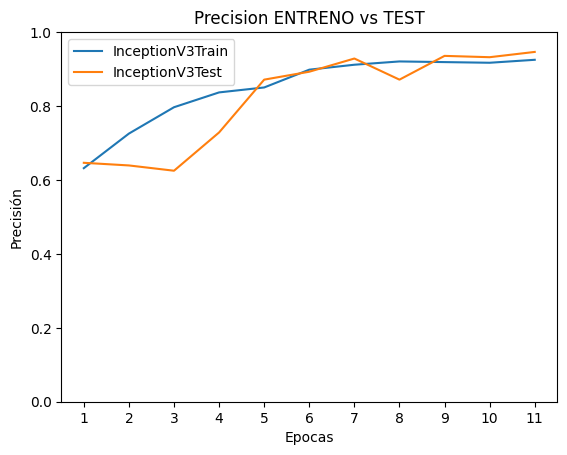

In [160]:
plt.title("Precision ENTRENO vs TEST")
plt.xlabel("Epocas")
plt.ylabel("Precisión")
plt.plot(range(1,epochs+1),accuracy_trainNN[0:epochs],label="InceptionV3Train")
plt.plot(range(1,epochs+1),accuracy_testNN[0:epochs],label="InceptionV3Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.show()

# Modelo con Datos transformados y sin Normalizar

In [71]:
model_ftImT,_= initialize_model2(2)
modelImT=model_ftImT.to(device)

model_ftImT.aux_logits=False

params_to_updateImT = model_ftImT.parameters()
print("Params to learn:")
params_to_updateImT = []
for name,param in model_ftImT.named_parameters():
    
    if (param.requires_grad == True) & (not ('AuxLogits' in name)):
        params_to_updateImT.append(param)
        print("\t",name)


print(model_ftImT.fc)


parametrosImT=sum(p.numel() for p in params_to_updateImT)



Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [72]:
epochs=4
lr=0.0001



print("Parameters ",parametrosImT)
optimizerx = optim.Adam(params_to_updateImT, lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_lx = np.zeros((12))
accuracy_trainx = np.zeros((12))
test_lx = np.zeros((12))
accuracy_testx = np.zeros((12))
print("ENTRENAMOS NUESTRA RED")
# Bucle d'entrenament
for epoch in range(0, epochs):
    train_lx[epoch],accuracy_trainx[epoch] = train(modelImT, device, train_dlx, optimizerx, epoch)
    test_lx[epoch],accuracy_testx[epoch]  = test(modelImT, device, test_dl2)

Parameters  21789666
ENTRENAMOS NUESTRA RED
Train Epoch: 0 [0/5610 (0%)]	Loss: 68.681107, Average: 0.686811
Train Epoch: 0 [100/5610 (2%)]	Loss: 66.627434, Average: 0.666274
Train Epoch: 0 [200/5610 (4%)]	Loss: 69.064590, Average: 0.690646
Train Epoch: 0 [300/5610 (5%)]	Loss: 69.948349, Average: 0.699483
Train Epoch: 0 [400/5610 (7%)]	Loss: 65.176216, Average: 0.651762
Train Epoch: 0 [500/5610 (9%)]	Loss: 67.483940, Average: 0.674839
Train Epoch: 0 [600/5610 (11%)]	Loss: 66.189224, Average: 0.661892
Train Epoch: 0 [700/5610 (12%)]	Loss: 64.713867, Average: 0.647139
Train Epoch: 0 [800/5610 (14%)]	Loss: 65.366508, Average: 0.653665
Train Epoch: 0 [900/5610 (16%)]	Loss: 65.162521, Average: 0.651625
Train Epoch: 0 [1000/5610 (18%)]	Loss: 63.696968, Average: 0.636970
Train Epoch: 0 [1100/5610 (19%)]	Loss: 62.709305, Average: 0.627093
Train Epoch: 0 [1200/5610 (21%)]	Loss: 61.914593, Average: 0.619146
Train Epoch: 0 [1300/5610 (23%)]	Loss: 60.104263, Average: 0.601043
Train Epoch: 0 [1400/5

Train Epoch: 2 [400/5610 (7%)]	Loss: 46.932930, Average: 0.469329
Train Epoch: 2 [500/5610 (9%)]	Loss: 43.799236, Average: 0.437992
Train Epoch: 2 [600/5610 (11%)]	Loss: 45.098274, Average: 0.450983
Train Epoch: 2 [700/5610 (12%)]	Loss: 41.016510, Average: 0.410165
Train Epoch: 2 [800/5610 (14%)]	Loss: 48.612053, Average: 0.486121
Train Epoch: 2 [900/5610 (16%)]	Loss: 41.873127, Average: 0.418731
Train Epoch: 2 [1000/5610 (18%)]	Loss: 43.137764, Average: 0.431378
Train Epoch: 2 [1100/5610 (19%)]	Loss: 44.065426, Average: 0.440654
Train Epoch: 2 [1200/5610 (21%)]	Loss: 39.952354, Average: 0.399524
Train Epoch: 2 [1300/5610 (23%)]	Loss: 46.944176, Average: 0.469442
Train Epoch: 2 [1400/5610 (25%)]	Loss: 44.275791, Average: 0.442758
Train Epoch: 2 [1500/5610 (26%)]	Loss: 40.079540, Average: 0.400795
Train Epoch: 2 [1600/5610 (28%)]	Loss: 40.069164, Average: 0.400692
Train Epoch: 2 [1700/5610 (30%)]	Loss: 40.033833, Average: 0.400338
Train Epoch: 2 [1800/5610 (32%)]	Loss: 41.475620, Averag

A continuacion hay entrenos auxiliares para demostrar como la hipotesis de que el entreno del clasificador con imagenes no normalizadas y transformadas aumenta su precision en la validacion con respecto a los otros modelos que se podra ver mas adelante.

In [93]:
train_lx[4],accuracy_trainx[4] = train(modelImT, device, train_dlx, optimizerx, 4)#5
test_lx[4],accuracy_testx[4]  = test(modelImT, device, test_dl2)
epochs=epochs+1

Train Epoch: 4 [0/5610 (0%)]	Loss: 41.712666, Average: 0.417127
Train Epoch: 4 [100/5610 (2%)]	Loss: 41.879517, Average: 0.418795
Train Epoch: 4 [200/5610 (4%)]	Loss: 38.830692, Average: 0.388307
Train Epoch: 4 [300/5610 (5%)]	Loss: 43.873924, Average: 0.438739
Train Epoch: 4 [400/5610 (7%)]	Loss: 44.892368, Average: 0.448924
Train Epoch: 4 [500/5610 (9%)]	Loss: 37.896801, Average: 0.378968
Train Epoch: 4 [600/5610 (11%)]	Loss: 41.787781, Average: 0.417878
Train Epoch: 4 [700/5610 (12%)]	Loss: 38.979885, Average: 0.389799
Train Epoch: 4 [800/5610 (14%)]	Loss: 40.414825, Average: 0.404148
Train Epoch: 4 [900/5610 (16%)]	Loss: 43.052898, Average: 0.430529
Train Epoch: 4 [1000/5610 (18%)]	Loss: 42.339230, Average: 0.423392
Train Epoch: 4 [1100/5610 (19%)]	Loss: 43.136356, Average: 0.431364
Train Epoch: 4 [1200/5610 (21%)]	Loss: 38.451118, Average: 0.384511
Train Epoch: 4 [1300/5610 (23%)]	Loss: 46.121792, Average: 0.461218
Train Epoch: 4 [1400/5610 (25%)]	Loss: 38.348003, Average: 0.38348

In [109]:
train_lx[5],accuracy_trainx[5] = train(modelImT, device, train_dlx, optimizerx, 5)#6
test_lx[5],accuracy_testx[5]  = test(modelImT, device, test_dl2)


Train Epoch: 5 [0/5610 (0%)]	Loss: 37.924751, Average: 0.379248
Train Epoch: 5 [100/5610 (2%)]	Loss: 38.972580, Average: 0.389726
Train Epoch: 5 [200/5610 (4%)]	Loss: 41.929317, Average: 0.419293
Train Epoch: 5 [300/5610 (5%)]	Loss: 44.471764, Average: 0.444718
Train Epoch: 5 [400/5610 (7%)]	Loss: 43.398888, Average: 0.433989
Train Epoch: 5 [500/5610 (9%)]	Loss: 39.164158, Average: 0.391642
Train Epoch: 5 [600/5610 (11%)]	Loss: 39.169952, Average: 0.391700
Train Epoch: 5 [700/5610 (12%)]	Loss: 41.649239, Average: 0.416492
Train Epoch: 5 [800/5610 (14%)]	Loss: 41.135677, Average: 0.411357
Train Epoch: 5 [900/5610 (16%)]	Loss: 42.706795, Average: 0.427068
Train Epoch: 5 [1000/5610 (18%)]	Loss: 41.255157, Average: 0.412552
Train Epoch: 5 [1100/5610 (19%)]	Loss: 38.296600, Average: 0.382966
Train Epoch: 5 [1200/5610 (21%)]	Loss: 41.888496, Average: 0.418885
Train Epoch: 5 [1300/5610 (23%)]	Loss: 38.432335, Average: 0.384323
Train Epoch: 5 [1400/5610 (25%)]	Loss: 37.610134, Average: 0.37610

In [113]:
train_lx[6],accuracy_trainx[6] = train(modelImT, device, train_dlx, optimizerx, 6)#7
test_lx[6],accuracy_testx[6]  = test(modelImT, device, test_dl2)
epochs=epochs+1

Train Epoch: 6 [0/5610 (0%)]	Loss: 39.330116, Average: 0.393301
Train Epoch: 6 [100/5610 (2%)]	Loss: 41.930820, Average: 0.419308
Train Epoch: 6 [200/5610 (4%)]	Loss: 38.932758, Average: 0.389328
Train Epoch: 6 [300/5610 (5%)]	Loss: 41.078148, Average: 0.410781
Train Epoch: 6 [400/5610 (7%)]	Loss: 39.195709, Average: 0.391957
Train Epoch: 6 [500/5610 (9%)]	Loss: 37.959854, Average: 0.379599
Train Epoch: 6 [600/5610 (11%)]	Loss: 40.701572, Average: 0.407016
Train Epoch: 6 [700/5610 (12%)]	Loss: 41.762650, Average: 0.417626
Train Epoch: 6 [800/5610 (14%)]	Loss: 39.714825, Average: 0.397148
Train Epoch: 6 [900/5610 (16%)]	Loss: 40.690990, Average: 0.406910
Train Epoch: 6 [1000/5610 (18%)]	Loss: 37.318226, Average: 0.373182
Train Epoch: 6 [1100/5610 (19%)]	Loss: 37.626038, Average: 0.376260
Train Epoch: 6 [1200/5610 (21%)]	Loss: 38.977322, Average: 0.389773
Train Epoch: 6 [1300/5610 (23%)]	Loss: 37.383522, Average: 0.373835
Train Epoch: 6 [1400/5610 (25%)]	Loss: 39.784588, Average: 0.39784

In [121]:
train_lx[7],accuracy_trainx[7] = train(modelImT, device, train_dlx, optimizerx, 7)#8
test_lx[7],accuracy_testx[7]  = test(modelImT, device, test_dl2)
epochs=epochs+1

Train Epoch: 7 [0/5610 (0%)]	Loss: 38.925140, Average: 0.389251
Train Epoch: 7 [100/5610 (2%)]	Loss: 41.943840, Average: 0.419438
Train Epoch: 7 [200/5610 (4%)]	Loss: 42.091228, Average: 0.420912
Train Epoch: 7 [300/5610 (5%)]	Loss: 41.174637, Average: 0.411746
Train Epoch: 7 [400/5610 (7%)]	Loss: 39.203487, Average: 0.392035
Train Epoch: 7 [500/5610 (9%)]	Loss: 40.490170, Average: 0.404902
Train Epoch: 7 [600/5610 (11%)]	Loss: 42.911236, Average: 0.429112
Train Epoch: 7 [700/5610 (12%)]	Loss: 44.670334, Average: 0.446703
Train Epoch: 7 [800/5610 (14%)]	Loss: 42.232040, Average: 0.422320
Train Epoch: 7 [900/5610 (16%)]	Loss: 40.748981, Average: 0.407490
Train Epoch: 7 [1000/5610 (18%)]	Loss: 46.302841, Average: 0.463028
Train Epoch: 7 [1100/5610 (19%)]	Loss: 40.206501, Average: 0.402065
Train Epoch: 7 [1200/5610 (21%)]	Loss: 42.082554, Average: 0.420826
Train Epoch: 7 [1300/5610 (23%)]	Loss: 37.800217, Average: 0.378002
Train Epoch: 7 [1400/5610 (25%)]	Loss: 39.150600, Average: 0.39150

In [128]:
train_lx[8],accuracy_trainx[8] = train(modelImT, device, train_dlx, optimizerx, 8)#9
test_lx[8],accuracy_testx[8]  = test(modelImT, device, test_dl2)
epochs=epochs+1

Train Epoch: 8 [0/5610 (0%)]	Loss: 40.676952, Average: 0.406770
Train Epoch: 8 [100/5610 (2%)]	Loss: 40.298290, Average: 0.402983
Train Epoch: 8 [200/5610 (4%)]	Loss: 39.180309, Average: 0.391803
Train Epoch: 8 [300/5610 (5%)]	Loss: 38.792839, Average: 0.387928
Train Epoch: 8 [400/5610 (7%)]	Loss: 38.620750, Average: 0.386208
Train Epoch: 8 [500/5610 (9%)]	Loss: 40.601181, Average: 0.406012
Train Epoch: 8 [600/5610 (11%)]	Loss: 40.651485, Average: 0.406515
Train Epoch: 8 [700/5610 (12%)]	Loss: 42.905354, Average: 0.429054
Train Epoch: 8 [800/5610 (14%)]	Loss: 37.670734, Average: 0.376707
Train Epoch: 8 [900/5610 (16%)]	Loss: 39.732925, Average: 0.397329
Train Epoch: 8 [1000/5610 (18%)]	Loss: 39.669594, Average: 0.396696
Train Epoch: 8 [1100/5610 (19%)]	Loss: 37.211739, Average: 0.372117
Train Epoch: 8 [1200/5610 (21%)]	Loss: 37.001041, Average: 0.370010
Train Epoch: 8 [1300/5610 (23%)]	Loss: 43.553532, Average: 0.435535
Train Epoch: 8 [1400/5610 (25%)]	Loss: 41.002483, Average: 0.41002

In [133]:
train_lx[9],accuracy_trainx[9] = train(modelImT, device, train_dlx, optimizerx, 9)#10
test_lx[9],accuracy_testx[9]  = test(modelImT, device, test_dl2)
epochs=epochs+1

Train Epoch: 9 [0/5610 (0%)]	Loss: 38.434853, Average: 0.384349
Train Epoch: 9 [100/5610 (2%)]	Loss: 42.168480, Average: 0.421685
Train Epoch: 9 [200/5610 (4%)]	Loss: 43.143532, Average: 0.431435
Train Epoch: 9 [300/5610 (5%)]	Loss: 42.451351, Average: 0.424514
Train Epoch: 9 [400/5610 (7%)]	Loss: 42.221569, Average: 0.422216
Train Epoch: 9 [500/5610 (9%)]	Loss: 38.476437, Average: 0.384764
Train Epoch: 9 [600/5610 (11%)]	Loss: 37.087975, Average: 0.370880
Train Epoch: 9 [700/5610 (12%)]	Loss: 38.341690, Average: 0.383417
Train Epoch: 9 [800/5610 (14%)]	Loss: 39.074261, Average: 0.390743
Train Epoch: 9 [900/5610 (16%)]	Loss: 40.050724, Average: 0.400507
Train Epoch: 9 [1000/5610 (18%)]	Loss: 45.845676, Average: 0.458457
Train Epoch: 9 [1100/5610 (19%)]	Loss: 41.505196, Average: 0.415052
Train Epoch: 9 [1200/5610 (21%)]	Loss: 37.162159, Average: 0.371622
Train Epoch: 9 [1300/5610 (23%)]	Loss: 42.138271, Average: 0.421383
Train Epoch: 9 [1400/5610 (25%)]	Loss: 39.062347, Average: 0.39062

In [140]:
train_lx[10],accuracy_trainx[10] = train(modelImT, device, train_dlx, optimizerx, 10)#11
test_lx[10],accuracy_testx[10]  = test(modelImT, device, test_dl2)
epochs=epochs+1

Train Epoch: 10 [0/5610 (0%)]	Loss: 40.499142, Average: 0.404991
Train Epoch: 10 [100/5610 (2%)]	Loss: 39.310238, Average: 0.393102
Train Epoch: 10 [200/5610 (4%)]	Loss: 38.205734, Average: 0.382057
Train Epoch: 10 [300/5610 (5%)]	Loss: 39.001324, Average: 0.390013
Train Epoch: 10 [400/5610 (7%)]	Loss: 37.837646, Average: 0.378376
Train Epoch: 10 [500/5610 (9%)]	Loss: 39.508244, Average: 0.395082
Train Epoch: 10 [600/5610 (11%)]	Loss: 43.450336, Average: 0.434503
Train Epoch: 10 [700/5610 (12%)]	Loss: 36.654018, Average: 0.366540
Train Epoch: 10 [800/5610 (14%)]	Loss: 41.105610, Average: 0.411056
Train Epoch: 10 [900/5610 (16%)]	Loss: 39.782452, Average: 0.397825
Train Epoch: 10 [1000/5610 (18%)]	Loss: 38.037022, Average: 0.380370
Train Epoch: 10 [1100/5610 (19%)]	Loss: 36.634281, Average: 0.366343
Train Epoch: 10 [1200/5610 (21%)]	Loss: 39.579018, Average: 0.395790
Train Epoch: 10 [1300/5610 (23%)]	Loss: 38.734058, Average: 0.387341
Train Epoch: 10 [1400/5610 (25%)]	Loss: 39.524929, A

#### Grafica de Precisión 

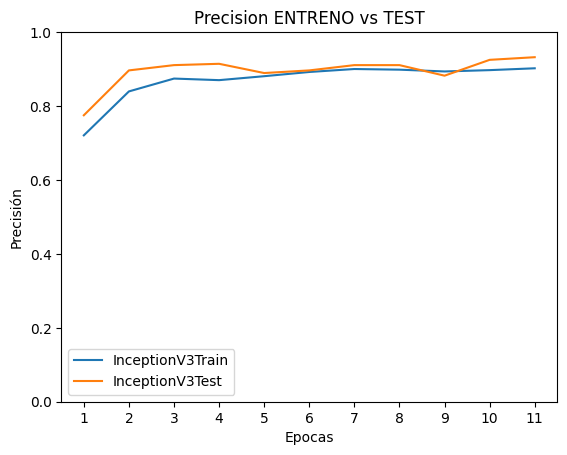

In [159]:
plt.title("Precision ENTRENO vs TEST")
plt.xlabel("Epocas")
plt.ylabel("Precisión")
plt.plot(range(1,epochs+1),accuracy_trainx[0:epochs],label="InceptionV3Train")
plt.plot(range(1,epochs+1),accuracy_testx[0:epochs],label="InceptionV3Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.show()

# Analisis 

## Comparar graficos entreno 

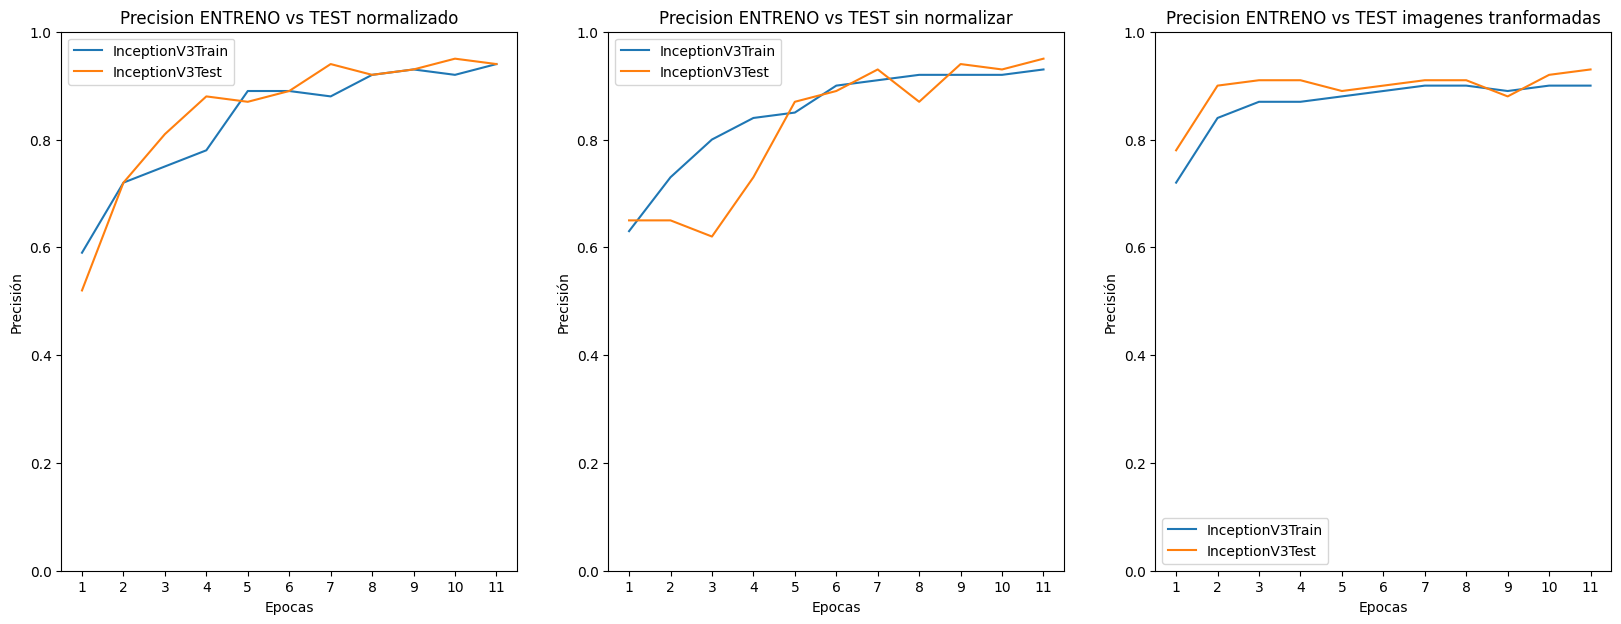

In [4]:

plt.figure(figsize=(20,7))

# Grafico 1
plt.subplot(1,3,1)
plt.title("Precision ENTRENO vs TEST normalizado")
plt.xlabel("Epocas")
plt.ylabel("Precisión")
plt.plot(range(1,epochs+1),accuracy_train[0:epochs],label="InceptionV3Train")
plt.plot(range(1,epochs+1),accuracy_test[0:epochs],label="InceptionV3Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()

# Grafico 2
plt.subplot(1,3,2)
plt.title("Precision ENTRENO vs TEST sin normalizar")
plt.xlabel("Epocas")
plt.ylabel("Precisión")
plt.plot(range(1,epochs+1),accuracy_trainNN[0:epochs],label="InceptionV3Train")
plt.plot(range(1,epochs+1),accuracy_testNN[0:epochs],label="InceptionV3Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.legend()



# Grafico 3
plt.subplot(1,3,3)
plt.title("Precision ENTRENO vs TEST imagenes tranformadas")
plt.xlabel("Epocas")
plt.ylabel("Precisión")
plt.plot(range(1,epochs+1),accuracy_trainx[0:epochs],label="InceptionV3Train")
plt.plot(range(1,epochs+1),accuracy_testx[0:epochs],label="InceptionV3Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()


plt.show()

Se observa en todos un patron de crecimiento en el test, sin embargo no es asi en la validación, ya que las normalizadas no pasa del 65%, en cambio en las no normalizadas y en las transformadas si se observa un notorio aumento en la precision en la validación. Esto es debido a que son capaces de detectar los cambios de color que es lo que se busca en este entreno.

## Comparar validacion 

##### Con 5 epocas 

In [106]:
print("La validacion del modelo con imagenes normalizadas y 5 epocas es:")
validacionNor = test(modelNor, device, val_dl)
print("La validacion del modelo con imagenes no normlizadas y 5 epocas es:")
validacionNN = test(modelNN, device, val_dl2)
print("La validacion del modelo con imagenes transformadas y 5 epocas es: ")
validacionImT = test(modelImT, device, val_dl2)



La validacion del modelo con imagenes normalizadas y 5 epocas es:

Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)

La validacion del modelo con imagenes no normlizadas y 5 epocas es:

Test set: Average loss: 0.6417, Accuracy: 63/98 (64%)

La validacion del modelo con imagenes transformadas y 5 epocas es: 

Test set: Average loss: 0.4913, Accuracy: 79/98 (81%)



##### Con 6 epocas 

In [112]:
print("La validacion del modelo con imagenes normalizadas y 6 epocas es:")
validacionNor = test(modelNor, device, val_dl)
print("La validacion del modelo con imagenes no normlizadas y 6 epocas es:")
validacionNN = test(modelNN, device, val_dl2)
print("La validacion del modelo con imagenes transformadas y 6 epocas es: ")
validacionImT = test(modelImT, device, val_dl2)


La validacion del modelo con imagenes normalizadas y 6 epocas es:

Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)

La validacion del modelo con imagenes no normlizadas y 6 epocas es:

Test set: Average loss: 0.6282, Accuracy: 64/98 (65%)

La validacion del modelo con imagenes transformadas y 6 epocas es: 

Test set: Average loss: 0.5225, Accuracy: 76/98 (78%)



##### Con 7 epocas 

In [117]:
validacionNor = test(modelNor, device, val_dl)
validacionNN = test(modelNN, device, val_dl2)
validacionImT = test(modelImT, device, val_dl2)

print("La validacion del modelo con imagenes normalizadas y 7 epocas es: ",validacionNor )
print("La validacion del modelo con imagenes no normlizadas y 7 epocas es: ",validacionNN )
print("La validacion del modelo con imagenes transformadas y 7 epocas es: ",validacionImT )


Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)


Test set: Average loss: 0.5754, Accuracy: 69/98 (70%)


Test set: Average loss: 0.4922, Accuracy: 80/98 (82%)

La validacion del modelo con imagenes normalizadas y 7 epocas es:  (tensor(0.6133), 0.6530612244897959)
La validacion del modelo con imagenes no normlizadas y 7 epocas es:  (tensor(0.5754), 0.7040816326530612)
La validacion del modelo con imagenes transformadas y 7 epocas es:  (tensor(0.4922), 0.8163265306122449)


##### Con 8 epocas 

In [125]:
validacionNor = test(modelNor, device, val_dl)
validacionNN = test(modelNN, device, val_dl2)
validacionImT = test(modelImT, device, val_dl2)

print("La validacion del modelo con imagenes normalizadas y 8 epocas es: ",validacionNor )
print("La validacion del modelo con imagenes no normlizadas y 8 epocas es: ",validacionNN )
print("La validacion del modelo con imagenes transformadas y 8 epocas es: ",validacionImT )


Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)


Test set: Average loss: 0.6465, Accuracy: 62/98 (63%)


Test set: Average loss: 0.5002, Accuracy: 80/98 (82%)

La validacion del modelo con imagenes normalizadas y 8 epocas es:  (tensor(0.6133), 0.6530612244897959)
La validacion del modelo con imagenes no normlizadas y 8 epocas es:  (tensor(0.6465), 0.6326530612244898)
La validacion del modelo con imagenes transformadas y 8 epocas es:  (tensor(0.5002), 0.8163265306122449)


##### Con 9 epocas 

In [132]:
validacionNor = test(modelNor, device, val_dl)
validacionNN = test(modelNN, device, val_dl2)
validacionImT = test(modelImT, device, val_dl2)

print("La validacion del modelo con imagenes normalizadas y 9 epocas es: ",validacionNor )
print("La validacion del modelo con imagenes no normlizadas y 9 epocas es: ",validacionNN )
print("La validacion del modelo con imagenes transformadas y 9 epocas es: ",validacionImT )


Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)


Test set: Average loss: 0.6065, Accuracy: 68/98 (69%)


Test set: Average loss: 0.5411, Accuracy: 76/98 (78%)

La validacion del modelo con imagenes normalizadas y 9 epocas es:  (tensor(0.6133), 0.6530612244897959)
La validacion del modelo con imagenes no normlizadas y 9 epocas es:  (tensor(0.6065), 0.6938775510204082)
La validacion del modelo con imagenes transformadas y 9 epocas es:  (tensor(0.5411), 0.7755102040816326)


##### Con 10 epocas 

In [137]:
validacionNor = test(modelNor, device, val_dl)
validacionNN = test(modelNN, device, val_dl2)
validacionImT = test(modelImT, device, val_dl2)

print("La validacion del modelo con imagenes normalizadas y 10 epocas es: ",validacionNor )
print("La validacion del modelo con imagenes no normlizadas y 10 epocas es: ",validacionNN )
print("La validacion del modelo con imagenes transformadas y 10 epocas es: ",validacionImT )


Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)


Test set: Average loss: 0.5582, Accuracy: 71/98 (72%)


Test set: Average loss: 0.5195, Accuracy: 78/98 (80%)

La validacion del modelo con imagenes normalizadas y 10 epocas es:  (tensor(0.6133), 0.6530612244897959)
La validacion del modelo con imagenes no normlizadas y 10 epocas es:  (tensor(0.5582), 0.7244897959183674)
La validacion del modelo con imagenes transformadas y 10 epocas es:  (tensor(0.5195), 0.7959183673469388)


##### Con 11 epocas 

In [143]:
validacionNor = test(modelNor, device, val_dl)
validacionNN = test(modelNN, device, val_dl2)
validacionImT = test(modelImT, device, val_dl2)

print("La validacion del modelo con imagenes normalizadas y 11 epocas es: ",validacionNor )
print("La validacion del modelo con imagenes no normlizadas y 11 epocas es: ",validacionNN )
print("La validacion del modelo con imagenes transformadas y 11 epocas es: ",validacionImT )


Test set: Average loss: 0.6133, Accuracy: 64/98 (65%)


Test set: Average loss: 0.5465, Accuracy: 75/98 (77%)


Test set: Average loss: 0.4448, Accuracy: 85/98 (87%)

La validacion del modelo con imagenes normalizadas y 10 epocas es:  (tensor(0.6133), 0.6530612244897959)
La validacion del modelo con imagenes no normlizadas y 10 epocas es:  (tensor(0.5465), 0.7653061224489796)
La validacion del modelo con imagenes transformadas y 10 epocas es:  (tensor(0.4448), 0.8673469387755102)


## Conclusion 

A pesar de la hipotesis inicial que se ha presentado se ha podedido observar que en el modelo de imagenes transformadas se ha podido obtener una exactitud muy alta, aunque tambien se ha visto un aumento lento pero seguro por parte de las imagenes no transformadas y no normalizadas. Como conclusion se utilizaran esos dos modelos para entrenar, dejando el de transformadas como esta y el de no transformadas le ofreceremos mas epocas de entreno para llegar a una exactitud mas adecuada, pero sobretodo para llegar a una especifidad mas alta, sin perder mucha precision en la clasificacion de ninguna de las dos clases, pues lo que se pretende es un clasificador que sea capaz de detectar las imagenes incorrectas.

# Entreno con el modelo sin normalizar

Al haber realizado los experimentos anteriores se ha concluido que la mejor opcion es entrenar un modelo con imagenes no transformadas y sin normalizar y dejar el de imagenes transformadas como esta entrenado y comparar los resultados alfinal y dejar los dos pesos guardados.A continuacion se entrenan 2 modelos con distintas epocas y se comprueba su correcto funcionamiento. Del que funcione con mejor eficiencia se guardaran los pesos para su posterior uso y no tener que volver a entrenarlo.

# Modelo Final

In [214]:
model_ftf,_= initialize_model2(2)
modelf=model_ftf.to(device)

model_ftf.aux_logits=False

params_to_updatef = model_ftf.parameters()
print("Params to learn:")
params_to_updatef = []
for name,param in model_ftf.named_parameters():
    
    if (param.requires_grad == True) & (not ('AuxLogits' in name)):
        params_to_updatef.append(param)
        print("\t",name)


print(model_ftf.fc)


parametrosf=sum(p.numel() for p in params_to_updatef)


C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [216]:
epochs=14
lr=0.0001



print("Parameters ",parametrosf)
optimizef = optim.Adam(params_to_updatef, lr=lr)

train_lf = np.zeros((epochs))
accuracy_trainf = np.zeros((epochs))
test_lf = np.zeros((epochs))
accuracy_testf = np.zeros((epochs))
print("Se entrena la red")

for epoch in range(0, epochs):
    train_lf[epoch],accuracy_trainf[epoch] = train(modelf, device, train_dl2, optimizef, epoch)
    test_lf[epoch],accuracy_testf[epoch]  = test(modelf, device, test_dl2)

Parameters  21789666
Se entrena la red
Train Epoch: 0 [0/1122 (0%)]	Loss: 71.352226, Average: 0.713522
Train Epoch: 0 [100/1122 (8%)]	Loss: 69.192131, Average: 0.691921
Train Epoch: 0 [200/1122 (17%)]	Loss: 70.292557, Average: 0.702926
Train Epoch: 0 [300/1122 (25%)]	Loss: 69.858490, Average: 0.698585
Train Epoch: 0 [400/1122 (33%)]	Loss: 67.450218, Average: 0.674502
Train Epoch: 0 [500/1122 (42%)]	Loss: 66.459045, Average: 0.664590
Train Epoch: 0 [600/1122 (50%)]	Loss: 64.687492, Average: 0.646875
Train Epoch: 0 [700/1122 (58%)]	Loss: 68.050636, Average: 0.680506
Train Epoch: 0 [800/1122 (67%)]	Loss: 66.592583, Average: 0.665926
Train Epoch: 0 [900/1122 (75%)]	Loss: 65.653709, Average: 0.656537
Train Epoch: 0 [1000/1122 (83%)]	Loss: 61.434616, Average: 0.614346
Train Epoch: 0 [1100/1122 (92%)]	Loss: 14.164639, Average: 0.643847

Train set: Average loss: 0.6731, Accuracy: 631/1122 (56%)


Test set: Average loss: 0.6668, Accuracy: 181/280 (65%)

Train Epoch: 1 [0/1122 (0%)]	Loss: 64.688


Test set: Average loss: 0.3769, Accuracy: 264/280 (94%)

Train Epoch: 9 [0/1122 (0%)]	Loss: 36.959652, Average: 0.369597
Train Epoch: 9 [100/1122 (8%)]	Loss: 36.466747, Average: 0.364667
Train Epoch: 9 [200/1122 (17%)]	Loss: 40.398453, Average: 0.403985
Train Epoch: 9 [300/1122 (25%)]	Loss: 38.485062, Average: 0.384851
Train Epoch: 9 [400/1122 (33%)]	Loss: 39.880154, Average: 0.398802
Train Epoch: 9 [500/1122 (42%)]	Loss: 37.466652, Average: 0.374667
Train Epoch: 9 [600/1122 (50%)]	Loss: 39.263401, Average: 0.392634
Train Epoch: 9 [700/1122 (58%)]	Loss: 40.410004, Average: 0.404100
Train Epoch: 9 [800/1122 (67%)]	Loss: 37.888638, Average: 0.378886
Train Epoch: 9 [900/1122 (75%)]	Loss: 40.437454, Average: 0.404375
Train Epoch: 9 [1000/1122 (83%)]	Loss: 37.282146, Average: 0.372821
Train Epoch: 9 [1100/1122 (92%)]	Loss: 9.324985, Average: 0.423863

Train set: Average loss: 0.3870, Accuracy: 1026/1122 (91%)


Test set: Average loss: 0.3933, Accuracy: 258/280 (92%)

Train Epoch: 10 [0/112

In [217]:
print("Validacion del modelo F")
validacion = test(modelf, device, val_dl2)

Validacion del modelo F

Test set: Average loss: 0.5380, Accuracy: 75/98 (77%)



In [218]:
model_ftx,_= initialize_model2(2)
modelx=model_ftx.to(device)

model_ftx.aux_logits=False

params_to_updatex = model_ftx.parameters()
print("Params to learn:")
params_to_updatex = []
for name,param in model_ftx.named_parameters():
    
    if (param.requires_grad == True) & (not ('AuxLogits' in name)):
        params_to_updatex.append(param)
        print("\t",name)


print(model_ftx.fc)


parametrosx=sum(p.numel() for p in params_to_updatex)


Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [219]:
epochs=17
lr=0.0001



print("Parameters ",parametrosx)
optimizer = optim.Adam(params_to_updatex, lr=lr)


train_lx = np.zeros((epochs))
accuracy_trainx = np.zeros((epochs))
test_lx = np.zeros((epochs))
accuracy_testx = np.zeros((epochs))
print("Se entrena la Red")

for epoch in range(0, epochs):
    train_lx[epoch],accuracy_trainx[epoch] = train(modelx, device, train_dl2, optimizer, epoch)
    test_lx[epoch],accuracy_testx[epoch]  = test(modelx, device, test_dl2)

Parameters  21789666
Se entrena la Red
Train Epoch: 0 [0/1122 (0%)]	Loss: 71.621796, Average: 0.716218
Train Epoch: 0 [100/1122 (8%)]	Loss: 71.150848, Average: 0.711508
Train Epoch: 0 [200/1122 (17%)]	Loss: 70.697182, Average: 0.706972
Train Epoch: 0 [300/1122 (25%)]	Loss: 67.413879, Average: 0.674139
Train Epoch: 0 [400/1122 (33%)]	Loss: 68.635460, Average: 0.686355
Train Epoch: 0 [500/1122 (42%)]	Loss: 66.232010, Average: 0.662320
Train Epoch: 0 [600/1122 (50%)]	Loss: 64.665543, Average: 0.646655
Train Epoch: 0 [700/1122 (58%)]	Loss: 66.118675, Average: 0.661187
Train Epoch: 0 [800/1122 (67%)]	Loss: 63.681602, Average: 0.636816
Train Epoch: 0 [900/1122 (75%)]	Loss: 63.332603, Average: 0.633326
Train Epoch: 0 [1000/1122 (83%)]	Loss: 65.386230, Average: 0.653862
Train Epoch: 0 [1100/1122 (92%)]	Loss: 12.916898, Average: 0.587132

Train set: Average loss: 0.6701, Accuracy: 662/1122 (59%)


Test set: Average loss: 0.6668, Accuracy: 181/280 (65%)

Train Epoch: 1 [0/1122 (0%)]	Loss: 64.020


Test set: Average loss: 0.3700, Accuracy: 267/280 (95%)

Train Epoch: 9 [0/1122 (0%)]	Loss: 36.154018, Average: 0.361540
Train Epoch: 9 [100/1122 (8%)]	Loss: 38.613647, Average: 0.386136
Train Epoch: 9 [200/1122 (17%)]	Loss: 38.060879, Average: 0.380609
Train Epoch: 9 [300/1122 (25%)]	Loss: 36.555462, Average: 0.365555
Train Epoch: 9 [400/1122 (33%)]	Loss: 38.436096, Average: 0.384361
Train Epoch: 9 [500/1122 (42%)]	Loss: 36.455772, Average: 0.364558
Train Epoch: 9 [600/1122 (50%)]	Loss: 42.364864, Average: 0.423649
Train Epoch: 9 [700/1122 (58%)]	Loss: 36.775143, Average: 0.367751
Train Epoch: 9 [800/1122 (67%)]	Loss: 40.765636, Average: 0.407656
Train Epoch: 9 [900/1122 (75%)]	Loss: 40.106934, Average: 0.401069
Train Epoch: 9 [1000/1122 (83%)]	Loss: 39.997623, Average: 0.399976
Train Epoch: 9 [1100/1122 (92%)]	Loss: 10.494678, Average: 0.477031

Train set: Average loss: 0.3875, Accuracy: 1021/1122 (91%)


Test set: Average loss: 0.3942, Accuracy: 256/280 (91%)

Train Epoch: 10 [0/11

In [222]:
print("Validacion del modelo X")
validacion = test(modelx, device, val_dl2)

Validacion del modelo X

Test set: Average loss: 0.5210, Accuracy: 78/98 (80%)



In [9]:
def especifidad(MatrizConfusion):
    espeficifadM=(MatrizConfusion[1][1]/(MatrizConfusion[1][1]+MatrizConfusion[1][0]))*100
    return round(espeficifadM)

In [10]:
def recall(MatrizConfusion):
    recallM=(MatrizConfusion[0][0]/(MatrizConfusion[0][0]+MatrizConfusion[0][1]))*100
    return round(recallM)

In [11]:
def PrecisionClasePositiva(MatrizConfusion):
    PreP=(MatrizConfusion[0][0]/(MatrizConfusion[0][0]+MatrizConfusion[1][0]))*100
    return round(PreP)

In [12]:
def PrecisionClaseNegativa(MatrizConfusion):
    PreN=(MatrizConfusion[1][1]/(MatrizConfusion[1][1]+MatrizConfusion[0][1]))*100
    return round(PreN)

In [13]:
def exactitud(MatrizConfusion):
    exactitudM=((MatrizConfusion[0][0]+MatrizConfusion[1][1])/(MatrizConfusion[0][0]+MatrizConfusion[0][1]+MatrizConfusion[1][1]+MatrizConfusion[1][0]))*100
    return round(exactitudM)

## Modelo X

In [14]:
etiquetas_reales = np.zeros(len(val_ds2))
etiquetas_predichas = np.zeros(len(val_ds2))
dfX = pd.DataFrame(columns=['porcentaje buenas', 'path','Prediccion','Target']) #Para su posterior escritura en un csv
modelx.eval() #Poner en modo evaluacion
for i in range(len(val_ds2)):
    img,target,path= val_ds2.__getitem__(i)
    etiquetas_reales[i]=target
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        
        prediccion = modelx(tensor_imagen)
        clase_mas_probable = torch.argmax(prediccion, dim=1)
        ##Prediccion[0][0] el % de buena calidad que tiene la imagen
        dfX.loc[i] = [prediccion[0][0].item(), path[23:],clase_mas_probable,target]
        etiquetas_predichas[i]=clase_mas_probable.item()

# obtener la matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_reales, etiquetas_predichas)

# imprimir la matriz de confusión
print("La matriz de confusion del Modelo X es: ")
print(matriz_confusion)

print("La precision de la clase de Buena calidad del Modelo X es de :",PrecisionClasePositiva(matriz_confusion),"%" )
print("El recall de la clase de Buena calidad del Modelo X es de :",recall(matriz_confusion),"%" )
print("La precision de la clase de Mala calidad del Modelo X es de :",PrecisionClaseNegativa(matriz_confusion),"%" )
print("La especifidad de la clase de Mala calidad del Modelo X es de :",especifidad(matriz_confusion),"%" )
print("La exactitud del Modelo X es de :",exactitud(matriz_confusion),"%" )

La matriz de confusion del Modelo X es: 
[[21 18]
 [ 2 57]]
La precision de la clase de Buena calidad del Modelo X es de : 91 %
El recall de la clase de Buena calidad del Modelo X es de : 54 %
La precision de la clase de Mala calidad del Modelo X es de : 76 %
La especifidad de la clase de Mala calidad del Modelo X es de : 97 %
La exactitud del Modelo X es de : 80 %


In [226]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_ordenado_descendenteX = dfX.sort_values(by=['porcentaje buenas'], ascending=False)
df_ordenado_descendenteX

,porcentaje buenas,path,Prediccion,Target
43,0.999998,Buena calidad/Imagen331.png,[tensor(0)],0
55,0.999998,Buena calidad/Imagen332.png,[tensor(0)],0
42,0.999998,Buena calidad/Imagen335.png,[tensor(0)],0
23,0.999996,Buena calidad/Imagen327.png,[tensor(0)],0
73,0.999989,Buena calidad/Imagen318.png,[tensor(0)],0
14,0.999988,Buena calidad/Imagen328.png,[tensor(0)],0
2,0.999955,Buena calidad/Imagen317.png,[tensor(0)],0
21,0.999885,Buena calidad/Imagen338_15050.png,[tensor(0)],0
61,0.999847,Buena calidad/Imagen330.png,[tensor(0)],0
1,0.999735,Buena calidad/Imagen334.png,[tensor(0)],0


## Modelo ImT

In [15]:
etiquetas_reales = np.zeros(len(val_ds2))
etiquetas_predichas = np.zeros(len(val_ds2))

dfIMT = pd.DataFrame(columns=['porcentaje buenas', 'path','Prediccion','Target']) #Para su posterior escritura en un csv
modelImT.eval() #Poner en modo evaluacion
for i in range(len(val_ds2)):
    img,target,path= val_ds2.__getitem__(i)
    etiquetas_reales[i]=target
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        prediccion = modelImT(tensor_imagen)
        clase_mas_probable = torch.argmax(prediccion, dim=1)
        #Prediccion[0][0] es el % de buena calidad que tiene la imagen
        dfIMT.loc[i] = [prediccion[0][0].item(), path[23:],clase_mas_probable,target]
        # Guardar la clase mas probable
        etiquetas_predichas[i]=clase_mas_probable.item()
    
           



# obtener la matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_reales, etiquetas_predichas)
print("La matriz de confusion del Modelo ImT es: ")
# imprimir la matriz de confusión
print(matriz_confusion)

print("La precision de la clase de Buena calidad del Modelo ImT es de :",PrecisionClasePositiva(matriz_confusion),"%" )
print("El recall de la clase de Buena calidad del Modelo ImT es de :",recall(matriz_confusion),"%" )
print("La precision de la clase de Mala calidad del Modelo ImT es de :",PrecisionClaseNegativa(matriz_confusion),"%" )
print("La especifidad de la clase de Mala calidad del Modelo ImT es de :",especifidad(matriz_confusion),"%" )
print("La exactitud del Modelo ImT es de :",exactitud(matriz_confusion),"%" )


La matriz de confusion del Modelo ImT es: 
[[33  6]
 [ 7 52]]
La precision de la clase de Buena calidad del Modelo ImT es de : 82 %
El recall de la clase de Buena calidad del Modelo ImT es de : 85 %
La precision de la clase de Mala calidad del Modelo ImT es de : 90 %
La especifidad de la clase de Mala calidad del Modelo ImT es de : 88 %
La exactitud del Modelo ImT es de : 87 %


In [228]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_ordenado_descendenteImT = dfIMT.sort_values(by=['porcentaje buenas'], ascending=False)
df_ordenado_descendenteImT

,porcentaje buenas,path,Prediccion,Target
66,1.000000e+00,Buena calidad/Imagen338_11050.png,[tensor(0)],0
2,1.000000e+00,Buena calidad/Imagen317.png,[tensor(0)],0
73,1.000000e+00,Buena calidad/Imagen318.png,[tensor(0)],0
21,1.000000e+00,Buena calidad/Imagen338_15050.png,[tensor(0)],0
65,9.999999e-01,Mala Calidad/Imagen502_2015.png,[tensor(0)],1
5,9.999999e-01,Buena calidad/Imagen502_5050.png,[tensor(0)],0
70,9.999999e-01,Buena calidad/Imagen329.png,[tensor(0)],0
39,9.999999e-01,Buena calidad/Imagen338_2050.png,[tensor(0)],0
90,9.999999e-01,Buena calidad/Imagen321_5050.png,[tensor(0)],0
47,9.999998e-01,Mala Calidad/Imagen502_5015.png,[tensor(0)],1


Como ha podido ser observado, el modelo ImT presenta mejores prestaciones en lo que a exactitud es referido, ademas refrente a la sensibilidad de la clase de buena calidad y la precision de la clase de mala calidad presenta mejores resultados, a diferencia del Modelo x. En general el modelo ImT dispone de una generalización mas adecuada. ya que para ambas clases dispone de una alta precision y una alta sensibilidad y especifidad, provocando asi que sea capaz de manejar de forma correcta las dos clases.

# Guardar Modelos

Se guardara los pesos de los dos modelos, ya que a pesar de que el modelo con las imagenes transformadas presenta mejores prestaciones, el modelo X presenta una especifidad mayor dejando un menor error a la hora de predecir las imagenes de mala calidad. Y si se desea seguir entrenando el modelo X donde su entreno es mas rapido. Pero el que presta mejor prestaciones es el modelo ImT, por ello este seria el resultado final del proyecto.

## Modelo X

In [229]:
PATH = '..\Pesos\modelx.pt' #Se indica en que carpeta se quiere guardar y el archivo donde se guarda
torch.save(modelx.state_dict(), PATH)

## Modelo ImT

In [230]:
PATH = '..\Pesos\modeltranformaciones.pt'
torch.save(modelImT.state_dict(), PATH)

# Descripcion de como Cargar un modelo

Se debe tener una instancia del modelo creada, para ello primero se tiene que definir el modelo. Con el siguiente codigo se define el modelo utilizado:

    def initialize_model2(num_classes):
        #Los pesos si se entrenan
        model_ft = models.inception_v3(weights=False) #Se carga el modelo inception_v3 sin sus pesos preentrenados.
        # False en las redes convencionales, se entrenaran
        set_parameter_requires_grad(model_ft, False)
        # Se modifica la red auxiliar
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

        #Se modifica la red principal para que sea de dos clases con una salida softmax y coger la con mas probabilidad.
        model_ft.dropout= nn.Dropout(0.5)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs,num_classes),
            nn.Dropout(0.3),
            nn.Softmax(dim=1)
        )

        input_size=299 #Tamaño que usa la red
        return model_ft,input_size
    


Y con la siguiente funcion:

    def set_parameter_requires_grad(model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False
            
            

Y a continuacion se instancia un modelo. Para hacer eso se deben utilizar las siguientes lineas de codigo:
Device cpu si no se dispone de cuda y si no  device = torch.device("cuda:0") con el indice deseado.

    device = torch.device("cpu")
    Modeloft,_= initialize_model2(2)
    Modelo=Modeloft.to(device)

    #Para inutilizar la capa auxiliar.
    Modeloft.aux_logits=False



Para poder cargar los pesos del modelo se hace con la siguiente linea:

    PATH = '..\Pesos\modeltranformaciones.pt'
    Modelo.load_state_dict(torch.load(PATH))
    


Y para finalizar para poder usarlo en modo prediccion hay que ponerlo en modo eval:

    Modelo.eval()



# Guardar metricas 


A continuacion se guardara el % de mala calidad de cada imagen de validacion en un dataframe  y en un csv. Dividido en dos csv. Uno con las de buena calidad y otro con los de mala calidad de validacion

## Buena Calidad

In [44]:
val_dsBuenaC = goodBadDataset(ValBuena_calidad, transform)

In [45]:
dfMetricasBuenasImagenes = pd.DataFrame(columns=['Nombre Imagen', '% Mala calidad Modelo IMT','% Mala calidad Modelo X']) #Para su posterior escritura en un csv
modelImT.eval() #Poner en modo evaluacion
modelx.eval()
for i in range(len(val_dsBuenaC)):
    img,target,path= val_dsBuenaC.__getitem__(i)
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        prediccionImT = modelImT(tensor_imagen)
        prediccionX = modelx(tensor_imagen)
        
        #Prediccion[0][1] es el % de mala calidad que tiene la imagen
        dfMetricasBuenasImagenes.loc[i] = [path[37:], '{:.6f}'.format(prediccionImT[0][1].item()* 100), '{:.6f}'.format(prediccionX[0][1].item()* 100)]
        
    
           


In [46]:
dfMetricasBuenasImagenes

,Nombre Imagen,% Mala calidad Modelo IMT,% Mala calidad Modelo X
0,Imagen309_11050.png,99.999976,95.453846
1,Imagen309_15050.png,99.999988,94.969374
2,Imagen309_2050.png,99.999869,99.810731
3,Imagen309_8050.png,99.999976,97.933668
4,Imagen310_15050.png,2.009903,1.997173
5,Imagen310_2050.png,0.194600,4.011867
6,Imagen315_15050.png,0.388630,91.072088
7,Imagen315_2050.png,1.502557,76.644450
8,Imagen317.png,0.000000,0.004499
9,Imagen318.png,0.000002,0.001123


In [47]:
dfMetricasBuenasImagenes.to_csv('..\Valores de calidad\Python\Metricas_Buenas_imagenes_Val_Modelos.csv', index=False)

## Mala Calidad

In [48]:
val_dsMalC = goodBadDataset(ValMala_calidad, transform)


In [49]:


dfMetricasMalasImagenes = pd.DataFrame(columns=['Nombre Imagen', '% Mala calidad Modelo IMT','% Mala calidad Modelo X']) #Para su posterior escritura en un csv
modelImT.eval() #Poner en modo evaluacion
modelx.eval()
for i in range(len(val_dsMalC)):
    img,target,path= val_dsMalC.__getitem__(i)
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        prediccionImT = modelImT(tensor_imagen)
        prediccionX = modelx(tensor_imagen)
        
        #Prediccion[0][1] es el % de mala calidad que tiene la imagen
        dfMetricasMalasImagenes.loc[i] = [path[36:], '{:.6f}'.format(prediccionImT[0][1].item()* 100), '{:.6f}'.format(prediccionX[0][1].item()* 100)]
        
    
           








In [50]:
dfMetricasMalasImagenes

,Nombre Imagen,% Mala calidad Modelo IMT,% Mala calidad Modelo X
0,Imagen309.png,99.999785,99.940443
1,Imagen309_205.png,99.975222,99.405354
2,Imagen310.png,99.999976,99.258077
3,Imagen310_1105.png,99.985802,99.986780
4,Imagen310_205.png,99.957019,99.944919
5,Imagen310_505.png,99.937868,99.944335
6,Imagen317_205.png,99.999845,99.998808
7,Imagen317_505.png,99.999750,99.999094
8,Imagen317_805.png,99.999630,99.998832
9,Imagen320.png,99.999976,99.988019


In [51]:
dfMetricasMalasImagenes.to_csv('..\Valores de calidad\Python\Metricas_malas_imagenes_Val_Modelos.csv', index=False)


# Pruebas con imagenes naturales¶

Se llevan a cabo pruebas adicionales utilizando imágenes naturales no vistas previamente, con el fin de demostrar la capacidad del modelo para asignar puntuaciones coherentes con la calidad de las imágenes, a pesar de haber sido entrenado utilizando conjuntos de datos modificados externamente mediante otro programa. Estas pruebas se realizan como parte de una validación adicional para evaluar la generalización del modelo en condiciones más cercanas a escenarios del mundo real.

In [14]:
PruebasB=os.listdir('..\Imagenes\Pruebas\Buena calidad/')
PruebasB = list(filter(lambda x: x != 'Prueba', PruebasB))
PruebasB= list(map(lambda  p: f"..\Imagenes\Pruebas\Buena calidad/{p}",PruebasB))

PruebasM=os.listdir('..\Imagenes\Pruebas\Mala Calidad/')
PruebasM = list(filter(lambda x: x != 'Prueba', PruebasM))
PruebasM= list(map(lambda  p: f"..\Imagenes\Pruebas\Mala Calidad/{p}",PruebasM))

Pruebas= PruebasB+PruebasM
print("Total de imagenes de Buena calidad en el dataset de pruebas", len(Pruebas))


Total de imagenes de Buena calidad en el dataset de validacion 22


In [15]:
pruebas_ds = goodBadDataset(Pruebas, transform)
pruebas_dl = DataLoader(pruebas_ds, batch_size=1)
print("Longitud del dataset de validacion normalizado: ",len(pruebas_ds))


Longitud del dataset de validacion normalizado:  22


In [20]:
dfMetricasPruebas = pd.DataFrame(columns=['Nombre Imagen', '% Mala calidad Modelo IMT','Clase real','Clase Predicha']) #Para su posterior escritura en un csv


for i in range(len(pruebas_ds)):
    img,target,path= pruebas_ds.__getitem__(i)
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        prediccionImT = modelImT(tensor_imagen)

        clase_mas_probable = torch.argmax(prediccionImT, dim=1)
        #Prediccion[0][1] es el % de mala calidad que tiene la imagen
        dfMetricasPruebas.loc[i] = [path[33:], '{:.6f}'.format(prediccionImT[0][1].item()* 100),target,clase_mas_probable]
        
    
           


In [21]:
dfMetricasPruebas

,Nombre Imagen,% Mala calidad Modelo IMT,Clase real,Clase Predicha
0,/Prueba10JPG.jpg,0.000084,0,[tensor(0)]
1,/Prueba10PNG.png,0.000051,0,[tensor(0)]
2,/Prueba11JPG.jpg,0.004754,0,[tensor(0)]
3,/Prueba11PNG.png,0.005206,0,[tensor(0)]
4,/Prueba1JPG.jpg,29.409170,0,[tensor(0)]
5,/Prueba1PNG.png,13.429955,0,[tensor(0)]
6,/Prueba2JPG.jpg,0.119911,0,[tensor(0)]
7,/Prueba2PNG.png,0.143713,0,[tensor(0)]
8,/Prueba3JPG.jpg,0.000150,0,[tensor(0)]
9,/Prueba3PNG.png,0.000183,0,[tensor(0)]


Se puede observar en la tabla que, a pesar del cambio de formato, se obtienen resultados similares y clasificaciones idénticas, lo cual indica que las puntuaciones asignadas por el modelo se corresponden adecuadamente con la calidad de las imágenes. Esta consistencia en los resultados refuerza la confiabilidad y coherencia del modelo en la evaluación de la calidad de las imágenes, independientemente del formato en el que se encuentren. Además, el modelo genera puntuaciones que se corresponden con la calidad real de las imágenes, asignando puntuaciones inferiores a 50 para las imágenes de buena calidad y puntuaciones superiores a 50 para las imágenes de mala calidad. Este patrón de asignación de puntuaciones demuestra la capacidad del modelo para discernir y clasificar adecuadamente la calidad de las imágenes, estableciendo un umbral objetivo que distingue entre las diferentes categorías de calidad para imagenes Naturales.

# Pruebas para ajustar parametros de LLCC

In [21]:
Pruebas=os.listdir('..\Imagenes\Pruebas\Ejemplo aplicacion/')
Pruebas = list(filter(lambda x: x != 'Prueba', Pruebas))
Pruebas= list(map(lambda  p: f"..\Imagenes\Pruebas\Ejemplo aplicacion/{p}",Pruebas))


print("Total de imagenes en el dataset de ejemplo aplicacion", len(Pruebas))


Total de imagenes en el dataset de ejemplo aplicacion 130


In [22]:
pruebas_ds = goodBadDataset(Pruebas, transform)
pruebas_dl = DataLoader(pruebas_ds, batch_size=1)
print("Longitud del dataset de validacion normalizado: ",len(pruebas_ds))


Longitud del dataset de validacion normalizado:  130


In [23]:
dfMetricasPruebas = pd.DataFrame(columns=['Nombre Imagen', '% Mala calidad Modelo IMT']) #Para su posterior escritura en un csv


for i in range(len(pruebas_ds)):
    img,target,path= pruebas_ds.__getitem__(i)
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        prediccionImT = modeloImT(tensor_imagen)

        clase_mas_probable = torch.argmax(prediccionImT, dim=1)
        #Prediccion[0][1] es el % de mala calidad que tiene la imagen
        dfMetricasPruebas.loc[i] = [path[33:], '{:.6f}'.format(prediccionImT[0][1].item()* 100)]
        
    
           


In [24]:

dfMetricasPruebas = dfMetricasPruebas.sort_values(by=['% Mala calidad Modelo IMT'], ascending=True)

In [25]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
dfMetricasPruebas

,Nombre Imagen,% Mala calidad Modelo IMT
119,acion/Prueba9PNG_2050.png,0.005976
72,acion/Prueba15PNG_5050.png,0.008247
77,acion/Prueba15PNG_8050.png,0.012238
117,acion/Prueba9PNG_2035.png,0.017105
114,acion/Prueba9PNG_15050.png,0.018601
124,acion/Prueba9PNG_5050.png,0.022513
109,acion/Prueba9PNG_11050.png,0.027599
129,acion/Prueba9PNG_8050.png,0.041219
122,acion/Prueba9PNG_5035.png,0.045623
67,acion/Prueba15PNG_2050.png,0.048636


Con el uso de la imagen Prueba8,Prueba9,Prueba11, Prueba14 y Prueba15 se ha podido observar que los parametros que mejor funcionan son para la escala espacial los de la siguiente lista : 20,50,80 y para el rango el 50 y 35 y que para el rango el parametro que peor funciona es el 5 y el 15.